<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Copy_of_Copy_of_Project_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Required Libraries

In [1]:
# This section imports all necessary libraries for data processing, similarity computation, evaluation, and visualization.
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Generate and Store Similarity Matrices for a Movie Recommendation System

This script generates the core similarity matrices required for building a hybrid movie recommendation system, using both user-based and content-based approaches.

1. **User-Based Similarity**
   Identifies similarities between users based on their movie rating behaviors to support collaborative filtering.

* *Cosine Similarity*: Measures the angle between users' rating vectors
* *Jaccard Similarity*: Measures the proportion of commonly rated movies between users

2. **Content-Based Similarity**
   Determines the similarity between movies based on their genre attributes to enable recommendations based on movie features.

* *Cosine Similarity*: Measures the angle between genre vectors
* *Jaccard Similarity*: Measures the overlap in genre tags between movies

All similarity matrices are saved locally, uploaded to GitHub and Google Drive, and will be used in subsequent scripts for generating personalized movie recommendations based on user and content similarities.


In [2]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from tqdm import tqdm

# --- Step 1: Load datasets ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print(f"Loaded {ratings['userId'].nunique()} users, {ratings['movieId'].nunique()} movies.")

# --- Step 2: Sample 10,000 users and save ratings ---
ratings_sampled_file = "ratings_sampled.csv"
if not os.path.exists(ratings_sampled_file):
    sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=42)
    ratings_sampled = ratings[ratings['userId'].isin(sampled_user_ids)]
    ratings_sampled.to_csv(ratings_sampled_file, index=False)
    print("Sampled ratings saved.")
else:
    ratings_sampled = pd.read_csv(ratings_sampled_file)
    print("Sampled ratings loaded from file.")

# --- Step 3: Create user-movie matrix ---
user_movie_matrix = ratings_sampled.pivot(index='userId', columns='movieId', values='rating')
user_ids = user_movie_matrix.index.tolist()
user_means = user_movie_matrix.mean(axis=1)

# --- Step 4a: Cosine Similarity (User-Based) ---
cosine_user_file = "cosine_user_similarity_sampled.csv"
if not os.path.exists(cosine_user_file):
    user_movie_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)
    cosine_sim_matrix = cosine_similarity(user_movie_centered.values)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_ids, columns=user_ids)
    cosine_sim_df.to_csv(cosine_user_file)
    print("Saved cosine user-user similarity matrix.")
else:
    print("Cosine user-user similarity matrix already exists.")

# --- Step 4b: Jaccard Similarity (User-Based) ---
jaccard_user_file = "jaccard_user_similarity_sampled.csv"
if not os.path.exists(jaccard_user_file):
    print("Computing Jaccard user-user similarity matrix...")
    user_movie_binary = user_movie_matrix.notna().astype(int)
    binary_array = user_movie_binary.values.astype(bool)
    intersection = np.dot(binary_array, binary_array.T)
    row_sums = binary_array.sum(axis=1, keepdims=True)
    union = row_sums + row_sums.T - intersection
    jaccard_sim_matrix = intersection / np.maximum(union, 1)
    jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=user_ids, columns=user_ids)
    jaccard_sim_df.to_csv(jaccard_user_file)
    print("Saved Jaccard user-user similarity matrix.")
else:
    print("Jaccard user-user similarity matrix already exists.")

# --- Step 4.5: One-hot encode the genre column ---
movies['genres'] = movies['genres'].fillna('')
genre_dummies = movies['genres'].str.get_dummies(sep='|')
unique_movies = pd.concat([movies[['movieId', 'title']], genre_dummies], axis=1)

# --- Step 5: Content-Based Similarity using Genre ---
genre_cols = genre_dummies.columns.tolist()
movie_ids = unique_movies['movieId'].tolist()
genre_matrix = unique_movies[genre_cols].values
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# --- Step 5a: Cosine Similarity (Content-Based) ---
cosine_content_file = "cosine_content_similarity.csv"
if not os.path.exists(cosine_content_file):
    cosine_content_sim = cosine_similarity(genre_matrix_normalized)
    cosine_content_df = pd.DataFrame(cosine_content_sim, index=movie_ids, columns=movie_ids)
    cosine_content_df.to_csv(cosine_content_file)
    print("Saved cosine content-based similarity matrix.")
else:
    print("Cosine content-based similarity matrix already exists.")

# --- Step 5b: Jaccard Similarity (Content-Based) ---
jaccard_content_file = "jaccard_content_similarity.csv"
if not os.path.exists(jaccard_content_file):
    print("Computing Jaccard content-based similarity matrix...")
    binary_array = genre_matrix.astype(bool)
    intersection = np.dot(binary_array, binary_array.T)
    row_sums = binary_array.sum(axis=1, keepdims=True)
    union = row_sums + row_sums.T - intersection
    jaccard_content_matrix = intersection / np.maximum(union, 1)
    jaccard_content_df = pd.DataFrame(jaccard_content_matrix, index=movie_ids, columns=movie_ids)
    jaccard_content_df.to_csv(jaccard_content_file)
    print("Saved Jaccard content-based similarity matrix.")
else:
    print("Jaccard content-based similarity matrix already exists.")

# --- Transpose to get movie-user matrix ---
movie_user_matrix = user_movie_matrix.T

# --- Fill missing ratings with 0 for cosine ---
movie_user_filled = movie_user_matrix.fillna(0)

# --- Step 6a: Cosine Similarity (Item-Item) ---
cosine_item_file = "cosine_item_similarity.csv"
if not os.path.exists(cosine_item_file):
    print("Computing cosine item-item similarity matrix...")
    cosine_item_matrix = cosine_similarity(movie_user_filled.values)
    cosine_item_df = pd.DataFrame(cosine_item_matrix, index=movie_user_matrix.index, columns=movie_user_matrix.index)
    cosine_item_df.to_csv(cosine_item_file)
    print("Saved cosine item-item similarity matrix.")
else:
    print("Cosine item-item similarity matrix already exists.")

# --- Step 6b: Jaccard Similarity (Item-Item) ---
jaccard_item_file = "jaccard_item_similarity.csv"
if not os.path.exists(jaccard_item_file):
    print("Computing Jaccard item-item similarity matrix...")
    movie_user_binary = movie_user_matrix.notna().astype(int)
    binary_array = movie_user_binary.values.astype(bool)
    intersection = np.dot(binary_array, binary_array.T)
    row_sums = binary_array.sum(axis=1, keepdims=True)
    union = row_sums + row_sums.T - intersection
    jaccard_item_matrix = intersection / np.maximum(union, 1)
    jaccard_item_df = pd.DataFrame(jaccard_item_matrix, index=movie_user_matrix.index, columns=movie_user_matrix.index)
    jaccard_item_df.to_csv(jaccard_item_file)
    print("Saved Jaccard item-item similarity matrix.")
else:
    print("Jaccard item-item similarity matrix already exists.")


Loaded 59029 users, 11190 movies.
Sampled ratings saved.
Saved cosine user-user similarity matrix.
Computing Jaccard user-user similarity matrix...
Saved Jaccard user-user similarity matrix.
Saved cosine content-based similarity matrix.
Computing Jaccard content-based similarity matrix...
Saved Jaccard content-based similarity matrix.
Computing cosine item-item similarity matrix...
Saved cosine item-item similarity matrix.
Computing Jaccard item-item similarity matrix...
Saved Jaccard item-item similarity matrix.


# Content-Based Recommender Systems

### Observations and Predictions Based Solely on Visualizations

#### 1. Genre Frequency by Ratings

* The most frequently occurring genres are Drama, Comedy, Action, and Thriller. These dominate the dataset by a large margin.
* Across nearly all genres, the most common ratings are 4.0 and 5.0, with a smaller but noticeable presence of 3.0 and 3.5.
* Ratings below 3.0 are relatively rare across all genres.
* Based on this, we can predict that any system relying on genre as input will disproportionately favor these high-frequency genres and likely produce higher predicted ratings.

#### 2. Histogram of Movie Ratings

* The distribution of ratings is clearly right-skewed, with modes at 4.0 and 5.0.
* There is a steep drop-off below 3.0, indicating that most users tend to give favorable ratings.
* This suggests a strong positivity bias in user feedback.
* A prediction model trained on this distribution will likely overpredict ratings, assigning values near the mean or mode (around 4.0) even in uncertain or ambiguous cases.

#### 3. User-Genre Heatmap: Average Ratings per Genre

* Many users have rated only a small subset of genres, suggesting sparse interactions across the genre space.
* Where ratings are present, they tend to cluster toward higher values (visibly darker shades).
* This implies that user profiles are dominated by high ratings for a few genres, potentially leading to overfitting on a small genre space.
* A content-based recommendation system using these profiles would likely produce inflated predicted ratings for movies in a user's historically preferred genres.

#### Overall Inference

* There is a strong upward bias in both the data distribution and in user behavior toward the higher end of the rating scale.
* Any recommendation system trained on this data, especially one that incorporates genre and user-specific preferences, will be predisposed to predict ratings near or above 4.0.
* The lack of sufficient low-rating examples may hinder the system's ability to accurately predict poor user-movie matches.
* Systems without proper normalization or regularization mechanisms may overestimate ratings due to the dominance of high-rating, high-frequency genres.


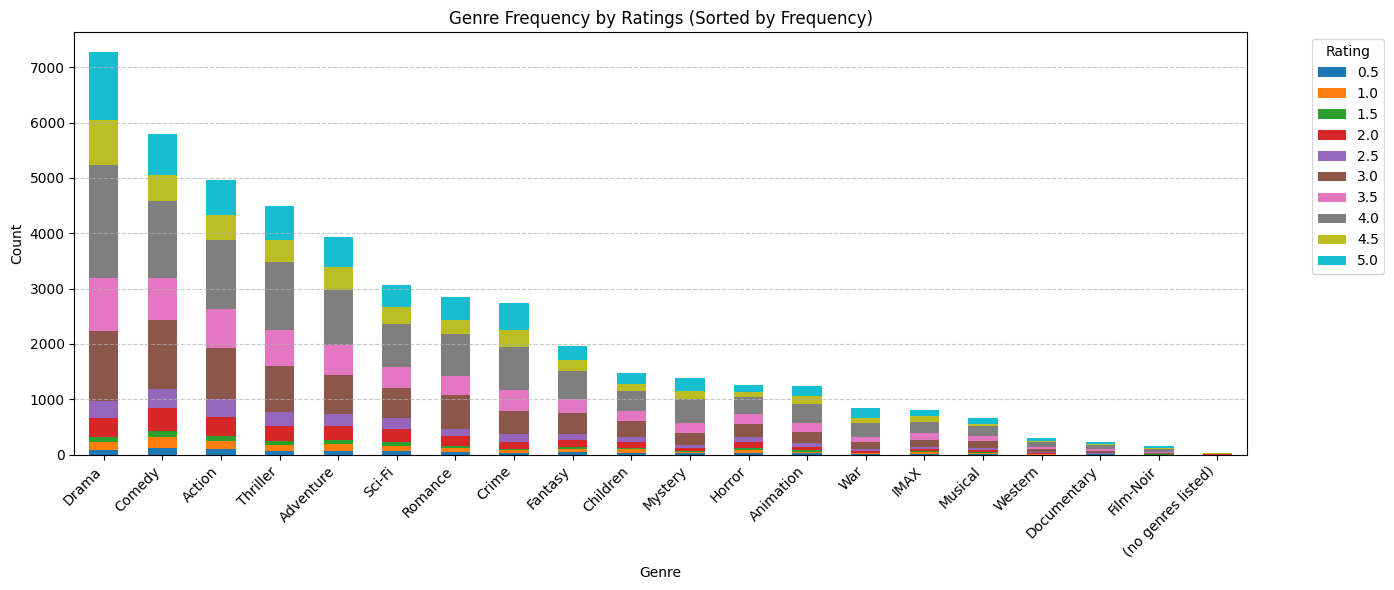

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")

# Merge ratings with movie genres
ratings_merged = ratings.merge(movies, on="movieId")

# Handle and explode genres
ratings_merged['genres'] = ratings_merged['genres'].fillna('').str.split('|')
ratings_exploded = ratings_merged.explode('genres')

# Create crosstab and sort genres by total count
genre_rating_counts = pd.crosstab(ratings_exploded['genres'], ratings_exploded['rating'])
genre_rating_counts = genre_rating_counts.loc[genre_rating_counts.sum(axis=1).sort_values(ascending=False).index]

# Plot sorted stacked bar chart
ax = genre_rating_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Genre Frequency by Ratings (Sorted by Frequency)")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


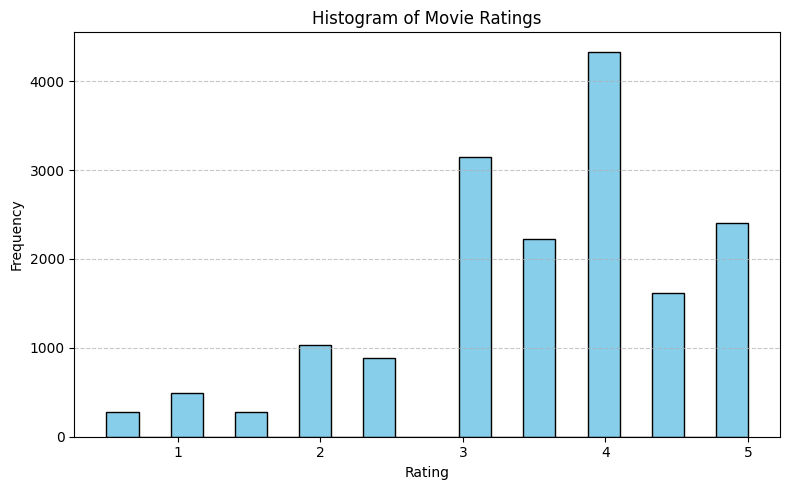

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")

# Plot histogram of ratings
plt.figure(figsize=(8, 5))
plt.hist(ratings['rating'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


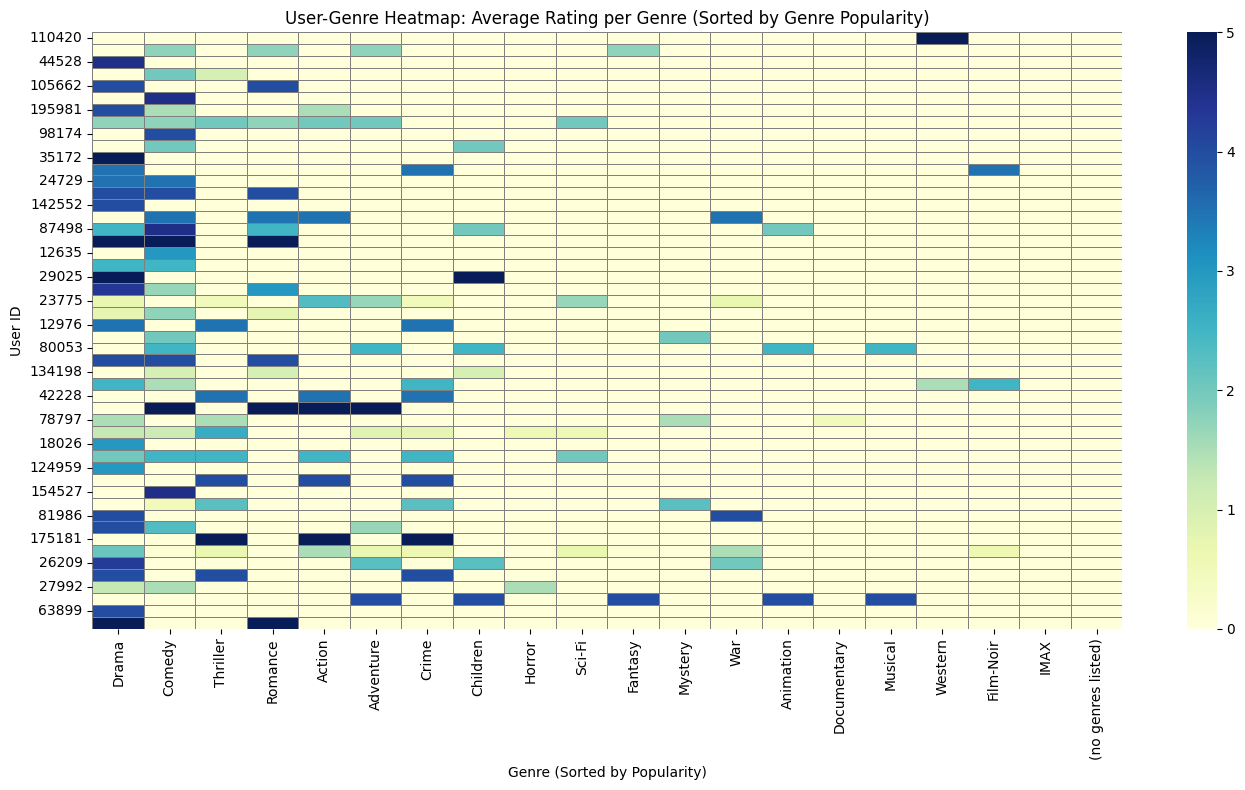

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")

# Prepare genre dummies
movies['genres'] = movies['genres'].fillna('')
genre_dummies = movies['genres'].str.get_dummies(sep='|')

# Merge with ratings
ratings_merged = ratings.merge(movies[['movieId']], on='movieId')
ratings_with_genres = ratings_merged.merge(genre_dummies, left_on='movieId', right_index=True)

# Multiply ratings by genre indicators
for genre in genre_dummies.columns:
    ratings_with_genres[genre] = ratings_with_genres[genre] * ratings_with_genres['rating']

# Compute average rating per user per genre
user_genre_avg = ratings_with_genres.groupby('userId')[genre_dummies.columns].mean()

# Compute overall average rating per genre for sorting
genre_avg_sorted = user_genre_avg.mean().sort_values(ascending=False)

# Reorder columns by genre popularity
user_genre_avg_sorted = user_genre_avg[genre_avg_sorted.index]

# Sample 50 users for readability
user_genre_sample = user_genre_avg_sorted.sample(n=50, random_state=42)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(user_genre_sample, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('User-Genre Heatmap: Average Rating per Genre (Sorted by Genre Popularity)')
plt.xlabel('Genre (Sorted by Popularity)')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()


## TF-IDF-Based Content-Based Recommender System

1. **Data Loading**
   Import movie metadata and user ratings from provided CSV sources. These form the input for profile creation and prediction.

2. **Genre Vectorization using TF-IDF**

   * Genres are tokenized and transformed into TF-IDF vectors.
   * Each movie is represented as a numerical vector indicating the importance of each genre.
   * Movies with no genre data are excluded.

3. **Train-Test Split and Matrix Construction**

   * Ratings are split 80/20 for training and testing.
   * A user-movie matrix is built from the training data to track what each user rated.
   * Fallback values (global and movie-level means) are precomputed for edge cases.

4. **User Profile Creation**

   * **Unweighted Profile**: A content-based profile that averages TF-IDF vectors of rated movies (ignores rating values).
   * **Weighted Profile**: A hybrid model that creates a personalized profile by weighting each genre vector by the user’s rating.

5. **Prediction Logic**

   * Predict ratings by computing cosine similarity between user profile and movie genre vector.
   * Similarity is scaled into the rating range (0.5 to 5).
   * Fallbacks are used if profile or genre vector is unavailable.

6. **Evaluation**

   * Predictions are generated for both unweighted (content-based) and weighted (hybrid) models.
   * Metrics used: RMSE, MAE, R².
   * Results are stored in a DataFrame for visualization.

7. **Visualization**

   * **Scatter Plot**: Compares predicted vs. actual ratings.
   * **Box Plot**: Distribution comparison between predicted and actual.
   * **KDE Plot**: Smoothed comparison of rating distributions.
   * **Faceted Scatter with Regression**: Compares unweighted and weighted predictions with annotated performance metrics.


In [43]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Step 1: Load Datasets ---
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Data loaded successfully.")

# --- Step 2: TF-IDF Genre Matrix ---
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf.fit_transform(movies['genres'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies['movieId'], columns=tfidf.get_feature_names_out())

# --- Step 3: Train-Test Split and Rating Stats ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 4a: Build Uncentered TF-IDF Profile ---
def build_uncentered_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    valid_movies = rated_movies.index.intersection(tfidf_df.index)
    if valid_movies.empty:
        return None
    return tfidf_df.loc[valid_movies].mean(axis=0).values

# --- Step 4b: Build Centered TF-IDF Profile (Weighted) ---
def build_centered_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    valid_movies = rated_movies.index.intersection(tfidf_df.index)
    if valid_movies.empty:
        return None
    centered_ratings = (rated_movies.loc[valid_movies] - rated_movies.mean()).values.reshape(-1, 1)
    genre_vectors = tfidf_df.loc[valid_movies].values
    return (centered_ratings.T @ genre_vectors / len(centered_ratings)).flatten()

# --- Step 5: Predict Rating with Profile Caching ---
profile_cache = {}

def predict_rating(user_id, movie_id, profile_type='uncentered'):
    if movie_id not in tfidf_df.index or user_id not in user_movie_matrix.index:
        return movie_means.get(movie_id, global_mean)

    # --- Caching ---
    if user_id not in profile_cache:
        profile_cache[user_id] = {
            "uncentered": build_uncentered_profile(user_id),
            "centered": build_centered_profile(user_id)
        }

    profile = profile_cache[user_id][profile_type]
    if profile is None:
        return movie_means.get(movie_id, global_mean)

    movie_vector = tfidf_df.loc[movie_id].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    baseline = movie_means.get(movie_id, global_mean)
    predicted_rating = baseline + sim * 1.0
    return max(0.5, min(predicted_rating, 5.0))


Data loaded successfully.


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Plot 1: Uncentered Profile (TF-IDF)

/tmp/ipython-input-44-2630249765.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes1[0, 1])


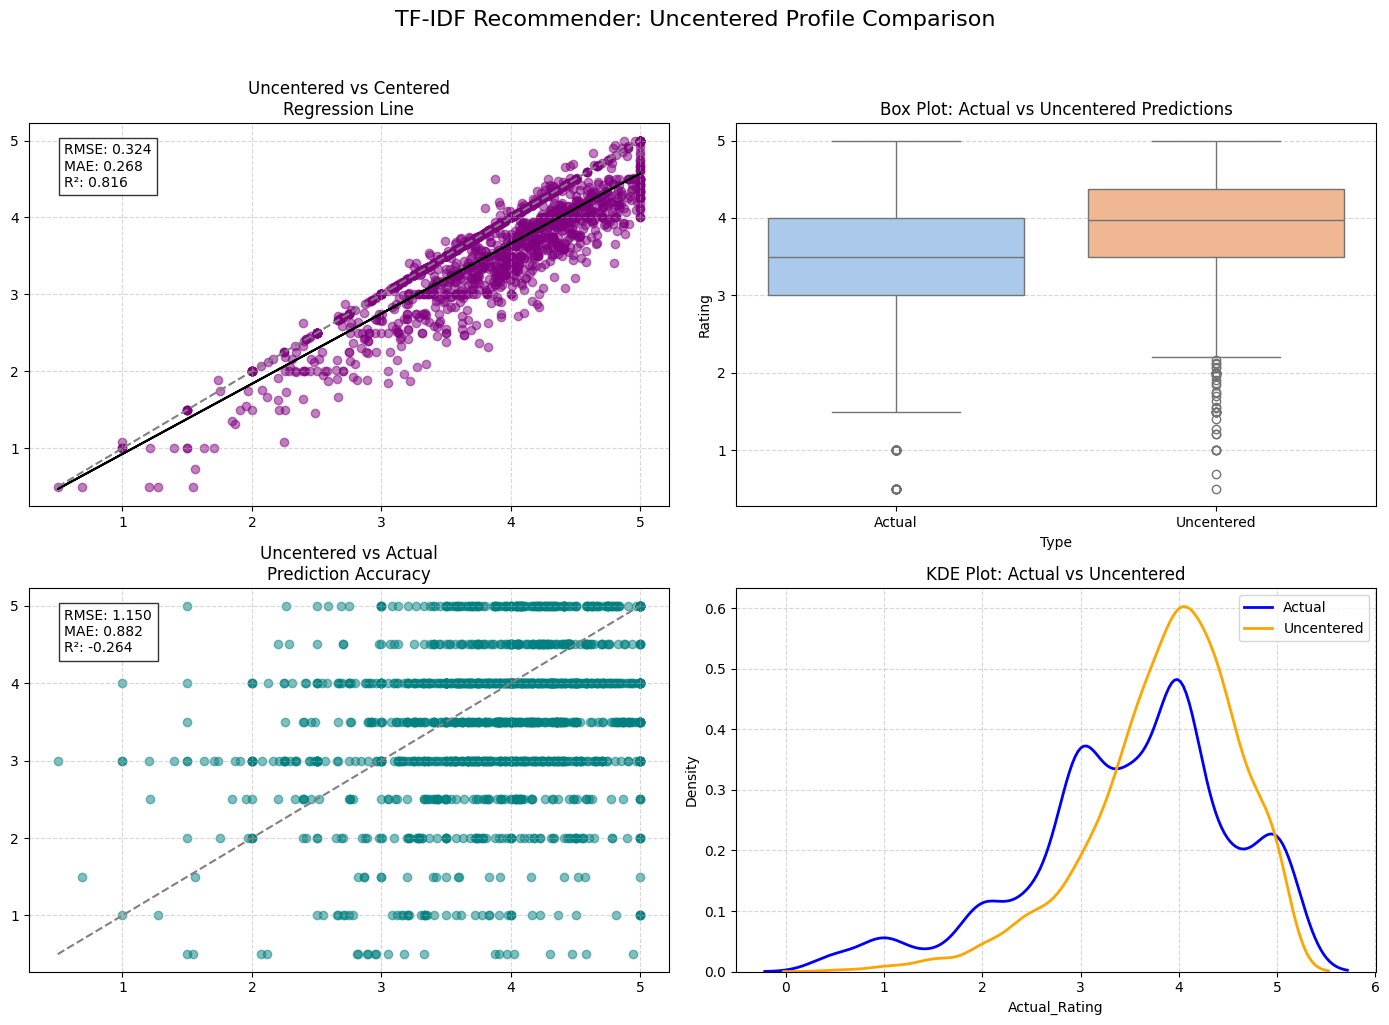

In [44]:
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))

# (1) Uncentered vs Centered
x = viz_df['Uncentered_Prediction'].values.reshape(-1, 1)
y = viz_df['Centered_Prediction'].values
reg = LinearRegression().fit(x, y)
line = reg.predict(x)
rmse = np.sqrt(mean_squared_error(y, line))
mae = mean_absolute_error(y, line)
r2 = r2_score(y, line)
axes1[0, 0].scatter(x, y, color='purple', alpha=0.5)
axes1[0, 0].plot(x, line, color='black')
axes1[0, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes1[0, 0].set_title('Uncentered vs Centered\nRegression Line')
axes1[0, 0].text(0.55, 4.4, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes1[0, 0].grid(True, linestyle='--', alpha=0.5)

# (2) Box Plot
melted = viz_df[['Actual_Rating', 'Uncentered_Prediction']].rename(
    columns={'Actual_Rating': 'Actual', 'Uncentered_Prediction': 'Uncentered'}
).melt(var_name='Type', value_name='Rating')
sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes1[0, 1])
axes1[0, 1].set_title('Box Plot: Actual vs Uncentered Predictions')
axes1[0, 1].grid(axis='y', linestyle='--', alpha=0.5)

# (3) Scatter
x2 = viz_df['Uncentered_Prediction']
y2 = viz_df['Actual_Rating']
rmse2 = np.sqrt(mean_squared_error(y2, x2))
mae2 = mean_absolute_error(y2, x2)
r2_2 = r2_score(y2, x2)
axes1[1, 0].scatter(x2, y2, alpha=0.5, color='teal')
axes1[1, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes1[1, 0].set_title('Uncentered vs Actual\nPrediction Accuracy')
axes1[1, 0].text(0.55, 4.4, f'RMSE: {rmse2:.3f}\nMAE: {mae2:.3f}\nR²: {r2_2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes1[1, 0].grid(True, linestyle='--', alpha=0.5)

# (4) KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes1[1, 1], color='blue', linewidth=2)
sns.kdeplot(viz_df['Uncentered_Prediction'], label='Uncentered', ax=axes1[1, 1], color='orange', linewidth=2)
axes1[1, 1].set_title('KDE Plot: Actual vs Uncentered')
axes1[1, 1].legend()
axes1[1, 1].grid(True, linestyle='--', alpha=0.5)

fig1.suptitle('TF-IDF Recommender: Uncentered Profile Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Plot 2: Centered Profile (TF-IDF)

/tmp/ipython-input-45-65909660.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes2[0, 1])


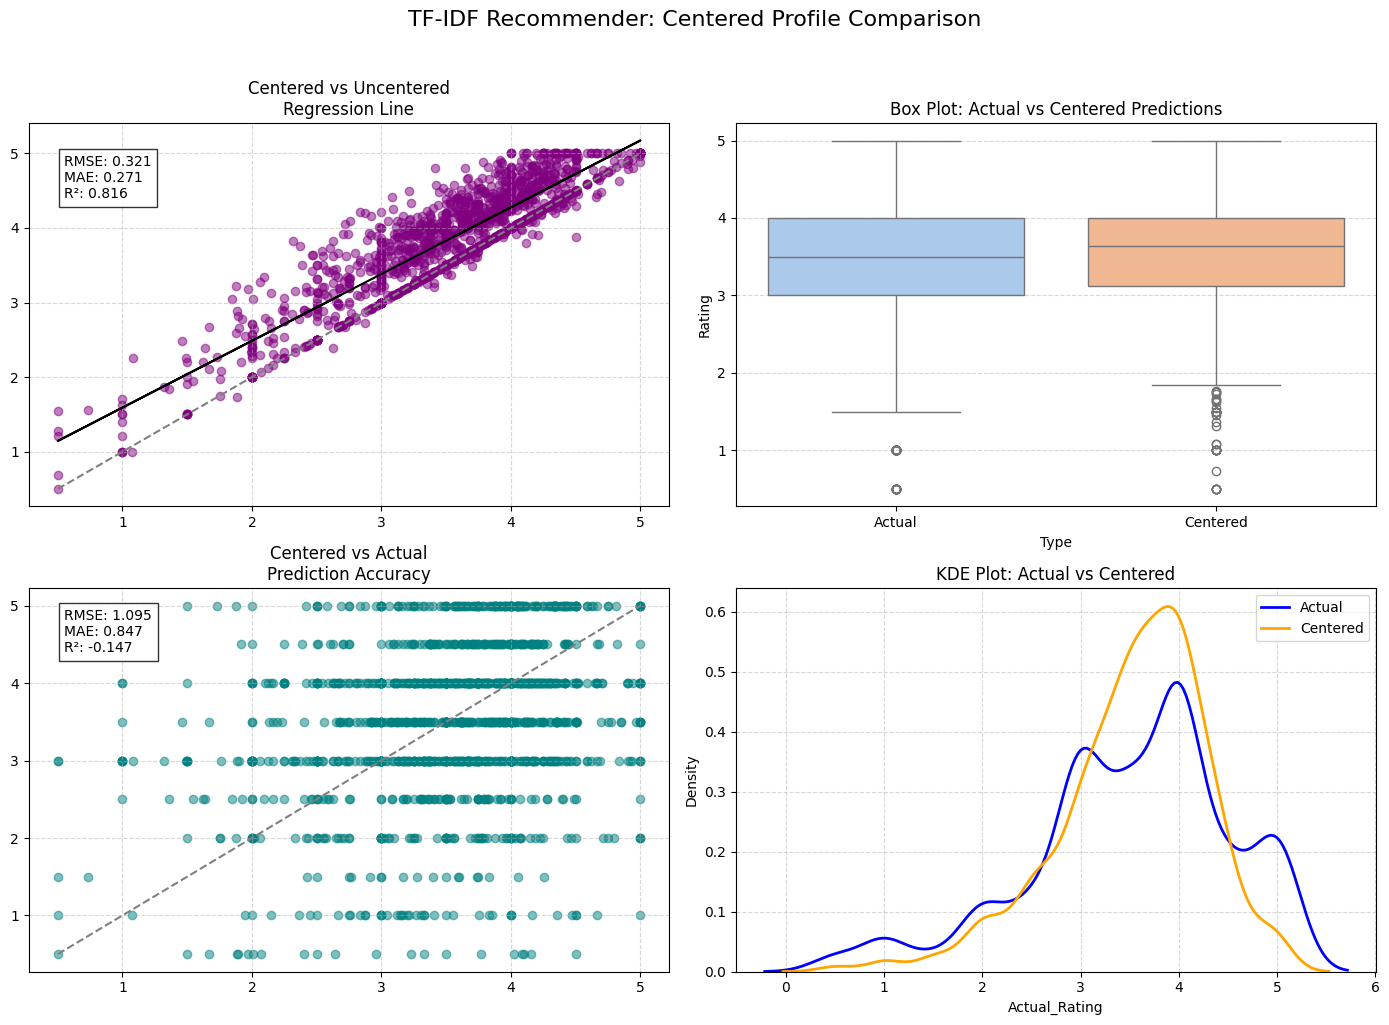

In [45]:
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

# (1) Centered vs Uncentered
x = viz_df['Centered_Prediction'].values.reshape(-1, 1)
y = viz_df['Uncentered_Prediction'].values
reg = LinearRegression().fit(x, y)
line = reg.predict(x)
rmse = np.sqrt(mean_squared_error(y, line))
mae = mean_absolute_error(y, line)
r2 = r2_score(y, line)
axes2[0, 0].scatter(x, y, color='purple', alpha=0.5)
axes2[0, 0].plot(x, line, color='black')
axes2[0, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes2[0, 0].set_title('Centered vs Uncentered\nRegression Line')
axes2[0, 0].text(0.55, 4.4, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes2[0, 0].grid(True, linestyle='--', alpha=0.5)

# (2) Box Plot
melted = viz_df[['Actual_Rating', 'Centered_Prediction']].rename(
    columns={'Actual_Rating': 'Actual', 'Centered_Prediction': 'Centered'}
).melt(var_name='Type', value_name='Rating')
sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes2[0, 1])
axes2[0, 1].set_title('Box Plot: Actual vs Centered Predictions')
axes2[0, 1].grid(axis='y', linestyle='--', alpha=0.5)

# (3) Scatter
x2 = viz_df['Centered_Prediction']
y2 = viz_df['Actual_Rating']
rmse2 = np.sqrt(mean_squared_error(y2, x2))
mae2 = mean_absolute_error(y2, x2)
r2_2 = r2_score(y2, x2)
axes2[1, 0].scatter(x2, y2, alpha=0.5, color='teal')
axes2[1, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes2[1, 0].set_title('Centered vs Actual\nPrediction Accuracy')
axes2[1, 0].text(0.55, 4.4, f'RMSE: {rmse2:.3f}\nMAE: {mae2:.3f}\nR²: {r2_2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes2[1, 0].grid(True, linestyle='--', alpha=0.5)

# (4) KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes2[1, 1], color='blue', linewidth=2)
sns.kdeplot(viz_df['Centered_Prediction'], label='Centered', ax=axes2[1, 1], color='orange', linewidth=2)
axes2[1, 1].set_title('KDE Plot: Actual vs Centered')
axes2[1, 1].legend()
axes2[1, 1].grid(True, linestyle='--', alpha=0.5)

fig2.suptitle('TF-IDF Recommender: Centered Profile Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## TF-Based Content Recommender System

**Objective**
This recommender system aims to predict how much a user will like a movie based only on its genre using Term Frequency (TF). It is a content-based system, meaning it recommends movies with similar characteristics to those the user liked in the past.

**1. Load Data**
Two datasets are used:

* `movies`: contains `movieId`, `title`, and `genres`
* `ratings`: contains `userId`, `movieId`, and `rating`

**2. Prepare Term-Frequency Matrix**
The `genres` column is split into binary flags for each genre using `get_dummies`. Each movie becomes a vector indicating which genres it belongs to. These vectors are normalized to ensure fair comparison across movies.

**3. Train-Test Split**
The `ratings` dataset is split into 80% training and 20% testing. A user-movie matrix is constructed from the training data to track what ratings each user gave to each movie.

**4. Build User Profile**
For each user, the system looks at all the movies they rated. It uses the genre vectors of those movies and weights them based on how much the user liked or disliked them compared to their own average rating. The result is a user profile vector that reflects their genre preferences.

**5. Predict Ratings**
To predict how much a user will like a new movie:

* The system retrieves the user’s profile and the genre vector for the movie.
* It calculates how similar they are using cosine similarity.
* That similarity is scaled and added to the average rating for that movie to produce the final prediction.
* If no profile or genre vector is available, the system falls back to the global or movie average.

**6. Evaluation**
The model is evaluated using:

* RMSE to measure average squared prediction error
* MAE to measure average absolute error
* R² to assess how much variance in ratings is explained
  Fallbacks are also counted for transparency.

**7. Visualizations**
The system produces:

* A box plot comparing predicted vs. actual ratings
* A histogram with overlaid KDE curves to show distribution
* A KDE-only plot to reveal alignment in rating patterns

**Similarity Technique Used**
Cosine similarity applied to genre vectors based on TF only (no IDF scaling). This emphasizes raw frequency of genre occurrence and is useful when IDF weighting adds unnecessary noise.


In [40]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Step 1: Load Datasets ---
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Data loaded successfully.")

# --- Step 2: Prepare TF Genre Matrix ---
movies['genres'] = movies['genres'].fillna('')
genre_tf = movies['genres'].str.get_dummies(sep='|')

# --- Step 3: Train-Test Split and Rating Stats ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 4a: Build Uncentered Profile (mean of TF vectors) ---
def build_uncentered_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    eligible_movies = genre_tf.loc[movies['movieId'].isin(rated_movies.index)]
    if eligible_movies.empty:
        return None
    return eligible_movies.mean(axis=0).values

# --- Step 4b: Build Centered Profile (rating-centered TF vectors) ---
def build_centered_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    eligible_movies = genre_tf.loc[movies['movieId'].isin(rated_movies.index)]
    if eligible_movies.empty:
        return None
    user_mean = rated_movies.mean()
    centered_ratings = (rated_movies - user_mean).values.reshape(-1, 1)
    return (centered_ratings.T @ eligible_movies.values / len(centered_ratings)).flatten()

# --- Step 5: Predict using cosine similarity (with profile cache) ---
profile_cache = {}

def predict_rating(user_id, movie_id, profile_type='uncentered'):
    if movie_id not in movie_means or user_id not in user_movie_matrix.index:
        return global_mean

    if user_id not in profile_cache:
        profile_cache[user_id] = {
            "uncentered": build_uncentered_profile(user_id),
            "centered": build_centered_profile(user_id)
        }

    profile = profile_cache[user_id][profile_type]
    if profile is None:
        return movie_means.get(movie_id, global_mean)

    movie_row_idx = movies[movies['movieId'] == movie_id].index
    if movie_row_idx.empty:
        return movie_means.get(movie_id, global_mean)

    movie_vector = genre_tf.iloc[movie_row_idx[0]].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    baseline = movie_means.get(movie_id, global_mean)
    predicted_rating = baseline + sim * 1.0
    return max(0.5, min(predicted_rating, 5.0))

# --- Step 6: Generate Predictions ---
true_ratings = []
pred_uncentered = []
pred_centered = []

for _, row in test_ratings.iterrows():
    uid = row['userId']
    mid = row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

# --- Step 7: Create DataFrame for Visualization ---
viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})


Data loaded successfully.


/tmp/ipython-input-40-1896350622.py:69: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))


### Faceted Plot 1: Uncentered Profile Comparison

/tmp/ipython-input-41-3440321509.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes1[0, 1])


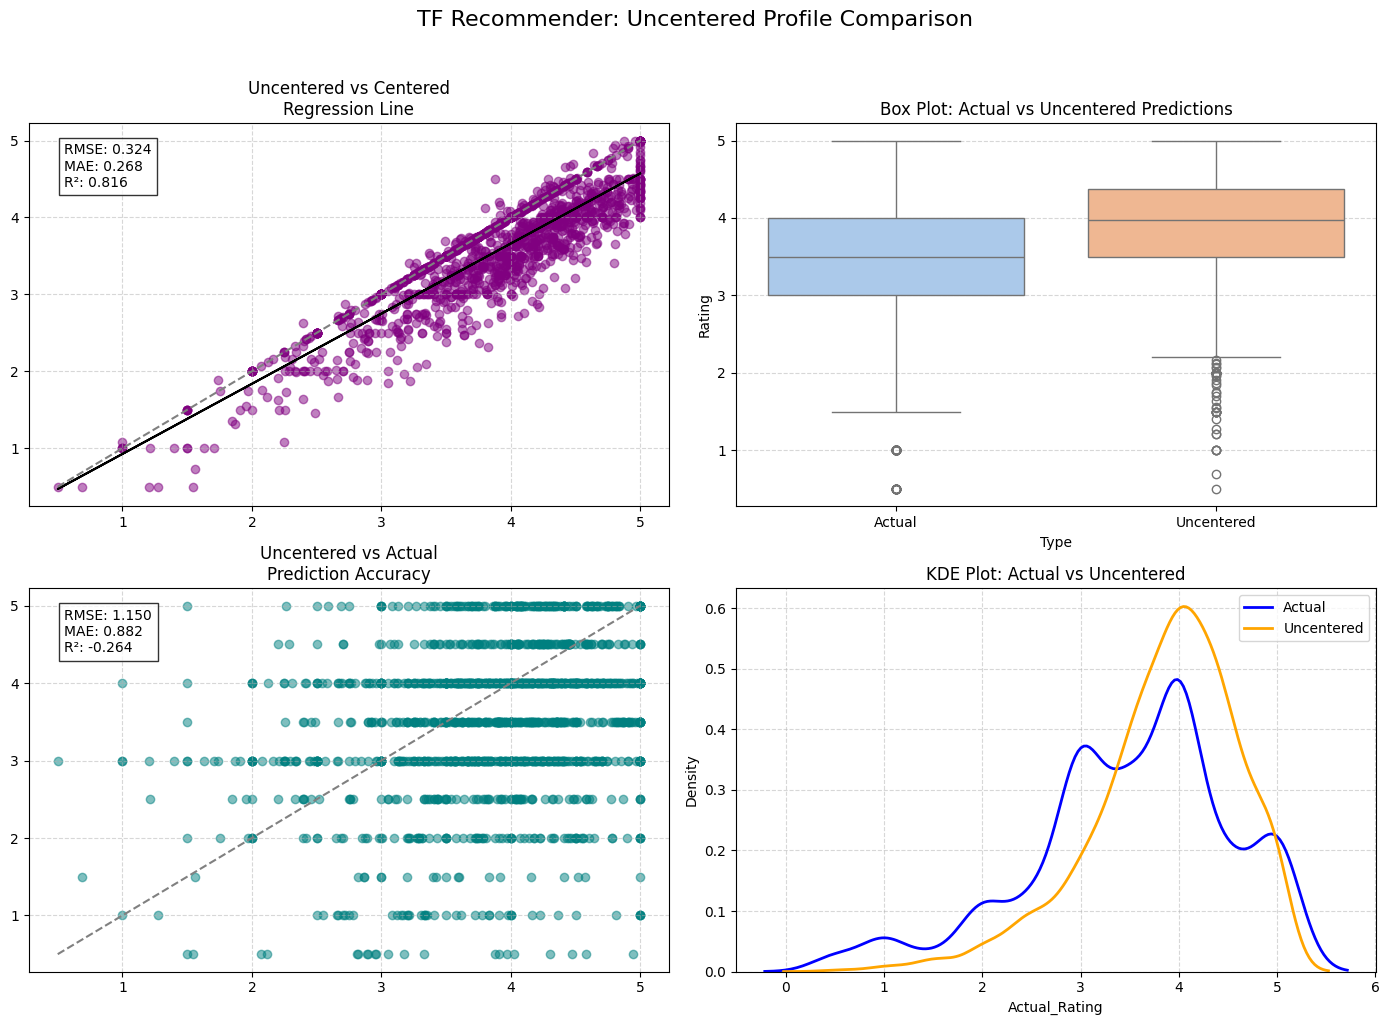

In [41]:
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))

# (1) Uncentered vs Centered
x = viz_df['Uncentered_Prediction'].values.reshape(-1, 1)
y = viz_df['Centered_Prediction'].values
reg = LinearRegression().fit(x, y)
line = reg.predict(x)
rmse = np.sqrt(mean_squared_error(y, line))
mae = mean_absolute_error(y, line)
r2 = r2_score(y, line)
axes1[0, 0].scatter(x, y, color='purple', alpha=0.5)
axes1[0, 0].plot(x, line, color='black')
axes1[0, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes1[0, 0].set_title('Uncentered vs Centered\nRegression Line')
axes1[0, 0].text(0.55, 4.4, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes1[0, 0].grid(True, linestyle='--', alpha=0.5)

# (2) Box Plot
melted = viz_df[['Actual_Rating', 'Uncentered_Prediction']].rename(
    columns={'Actual_Rating': 'Actual', 'Uncentered_Prediction': 'Uncentered'}
).melt(var_name='Type', value_name='Rating')
sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes1[0, 1])
axes1[0, 1].set_title('Box Plot: Actual vs Uncentered Predictions')
axes1[0, 1].grid(axis='y', linestyle='--', alpha=0.5)

# (3) Scatter
x2 = viz_df['Uncentered_Prediction']
y2 = viz_df['Actual_Rating']
rmse2 = np.sqrt(mean_squared_error(y2, x2))
mae2 = mean_absolute_error(y2, x2)
r2_2 = r2_score(y2, x2)
axes1[1, 0].scatter(x2, y2, alpha=0.5, color='teal')
axes1[1, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes1[1, 0].set_title('Uncentered vs Actual\nPrediction Accuracy')
axes1[1, 0].text(0.55, 4.4, f'RMSE: {rmse2:.3f}\nMAE: {mae2:.3f}\nR²: {r2_2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes1[1, 0].grid(True, linestyle='--', alpha=0.5)

# (4) KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes1[1, 1], color='blue', linewidth=2)
sns.kdeplot(viz_df['Uncentered_Prediction'], label='Uncentered', ax=axes1[1, 1], color='orange', linewidth=2)
axes1[1, 1].set_title('KDE Plot: Actual vs Uncentered')
axes1[1, 1].legend()
axes1[1, 1].grid(True, linestyle='--', alpha=0.5)

fig1.suptitle('TF Recommender: Uncentered Profile Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Faceted Plot 2: Centered Profile Comparison

/tmp/ipython-input-42-3615068056.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes2[0, 1])


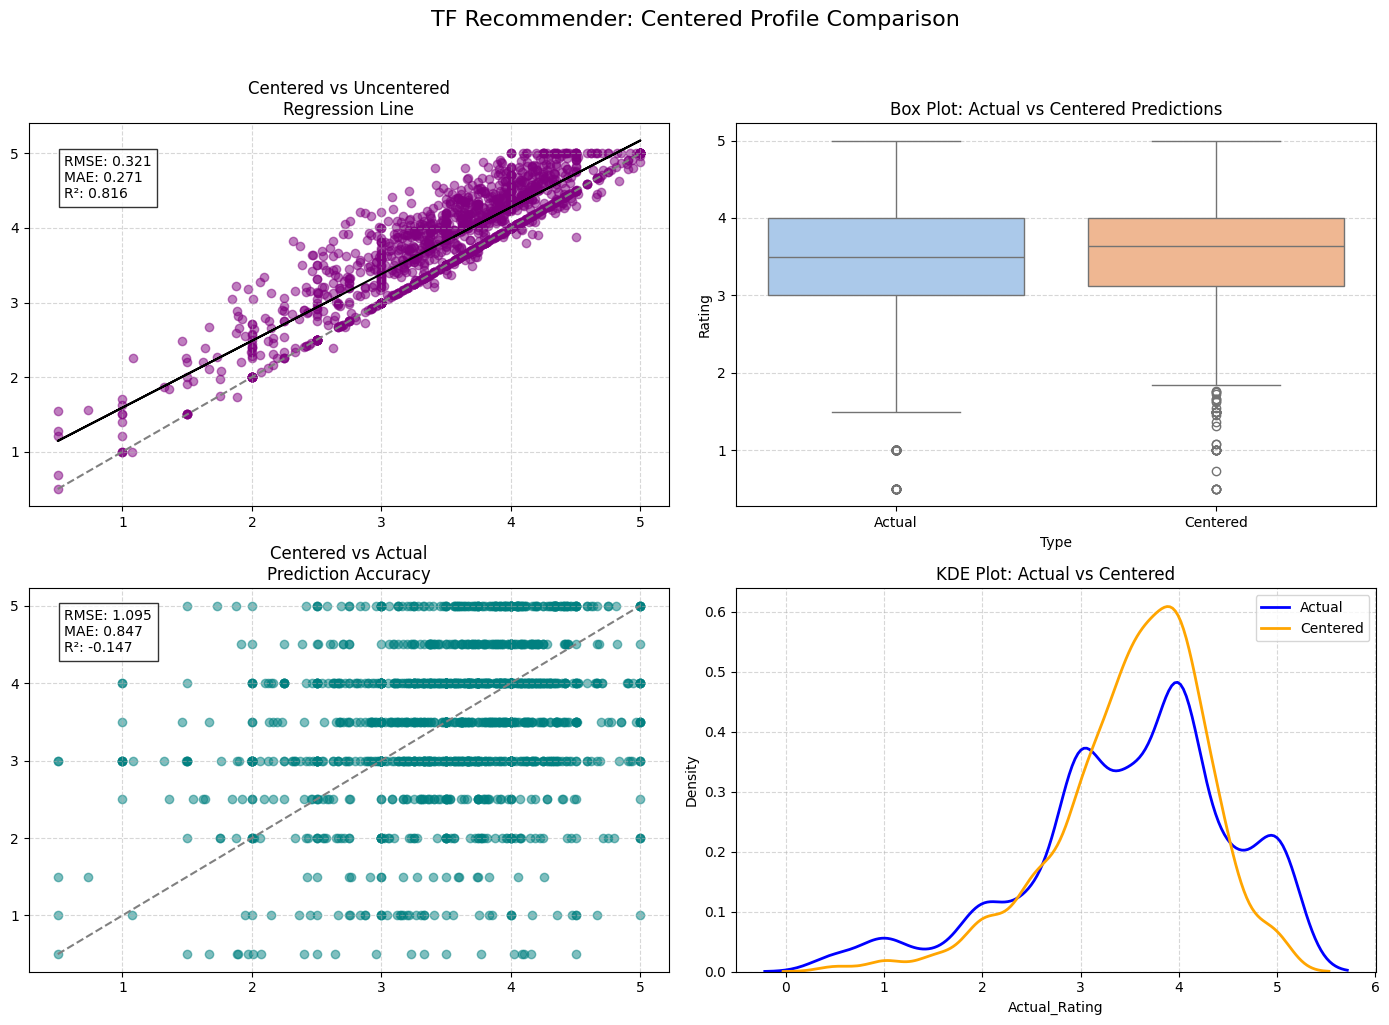

In [42]:
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

# (1) Centered vs Uncentered
x = viz_df['Centered_Prediction'].values.reshape(-1, 1)
y = viz_df['Uncentered_Prediction'].values
reg = LinearRegression().fit(x, y)
line = reg.predict(x)
rmse = np.sqrt(mean_squared_error(y, line))
mae = mean_absolute_error(y, line)
r2 = r2_score(y, line)
axes2[0, 0].scatter(x, y, color='purple', alpha=0.5)
axes2[0, 0].plot(x, line, color='black')
axes2[0, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes2[0, 0].set_title('Centered vs Uncentered\nRegression Line')
axes2[0, 0].text(0.55, 4.4, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes2[0, 0].grid(True, linestyle='--', alpha=0.5)

# (2) Box Plot
melted = viz_df[['Actual_Rating', 'Centered_Prediction']].rename(
    columns={'Actual_Rating': 'Actual', 'Centered_Prediction': 'Centered'}
).melt(var_name='Type', value_name='Rating')
sns.boxplot(data=melted, x='Type', y='Rating', palette='pastel', ax=axes2[0, 1])
axes2[0, 1].set_title('Box Plot: Actual vs Centered Predictions')
axes2[0, 1].grid(axis='y', linestyle='--', alpha=0.5)

# (3) Scatter
x2 = viz_df['Centered_Prediction']
y2 = viz_df['Actual_Rating']
rmse2 = np.sqrt(mean_squared_error(y2, x2))
mae2 = mean_absolute_error(y2, x2)
r2_2 = r2_score(y2, x2)
axes2[1, 0].scatter(x2, y2, alpha=0.5, color='teal')
axes2[1, 0].plot([0.5, 5], [0.5, 5], linestyle='--', color='gray')
axes2[1, 0].set_title('Centered vs Actual\nPrediction Accuracy')
axes2[1, 0].text(0.55, 4.4, f'RMSE: {rmse2:.3f}\nMAE: {mae2:.3f}\nR²: {r2_2:.3f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes2[1, 0].grid(True, linestyle='--', alpha=0.5)

# (4) KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes2[1, 1], color='blue', linewidth=2)
sns.kdeplot(viz_df['Centered_Prediction'], label='Centered', ax=axes2[1, 1], color='orange', linewidth=2)
axes2[1, 1].set_title('KDE Plot: Actual vs Centered')
axes2[1, 1].legend()
axes2[1, 1].grid(True, linestyle='--', alpha=0.5)

fig2.suptitle('TF Recommender: Centered Profile Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Content-Based Movie Recommender Using Cosine Similarity on Genre Vectors (one-hot encoded into binary vectors)

**Methodology Overview:**

This recommender system applies a *content-based filtering* approach by leveraging the genre information of movies to make personalized predictions for users. The methodology consists of the following steps:

1. **Data Loading:**
   Two datasets are loaded — one with movie metadata (including genres) and another with user ratings.

2. **Genre Feature Engineering:**
   Movie genres are one-hot encoded into binary vectors, forming a genre matrix where each movie is represented by its genre profile.

3. **Cosine Similarity Computation:**
   Each genre vector is normalized, and cosine similarity is computed between all movies, generating a matrix that captures how similar movies are based on genre.

4. **Train-Test Split:**
   The ratings data is split into training and testing subsets using an 80/20 ratio.

5. **User Profile Construction:**
   For each user in the training set, a centered user profile is built by weighting the genres of rated movies according to how much the user deviated from their average rating. This creates a personalized genre preference vector for each user.

6. **Prediction Function:**
   The predicted rating for a user-movie pair is computed by:

   * Finding the cosine similarity between the user’s genre profile and the target movie’s genre vector.
   * Scaling this similarity score and adding it to the movie’s average rating to adjust for popularity bias.
   * Fallback strategies are applied if either the user profile or movie genre vector is unavailable.

7. **Evaluation:**
   The model is evaluated on the test set using three performance metrics:

   * RMSE (Root Mean Squared Error)
   * MAE (Mean Absolute Error)
   * R² Score (Coefficient of Determination)

8. **Visualization:**
   The actual vs. predicted ratings are compared visually using:

   * A box plot to compare distribution spreads
   * Overlapping histograms with KDE to show density distributions
   * A dedicated KDE plot to highlight estimation curves for both actual and predicted ratings

This methodology provides personalized predictions using only genre information, making it suitable for cold-start scenarios where user interactions are sparse but content features are available.


Data loaded successfully.
Cosine Genre RMSE: 1.1043
Cosine Genre MAE : 0.8487
Cosine Genre R²  : -0.1295


/tmp/ipython-input-8-3442930673.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Rating', data=melted_df_cosine, palette='pastel')


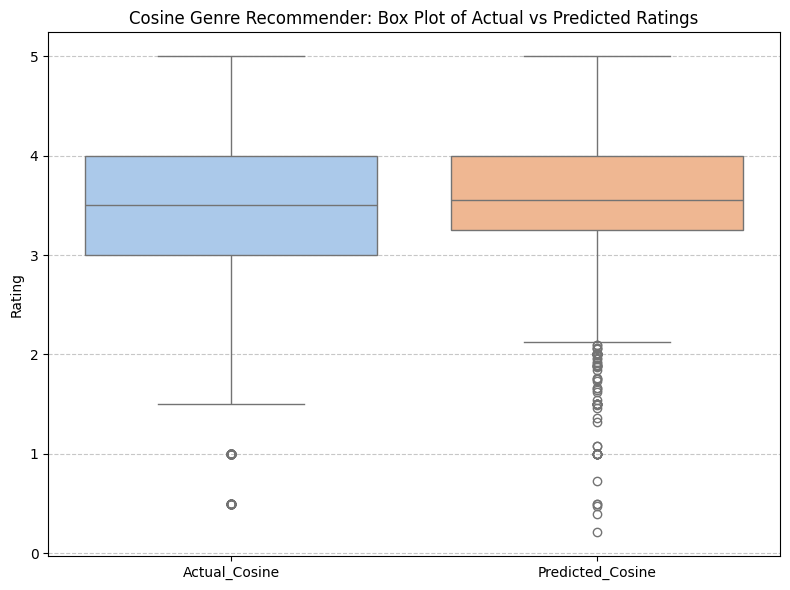

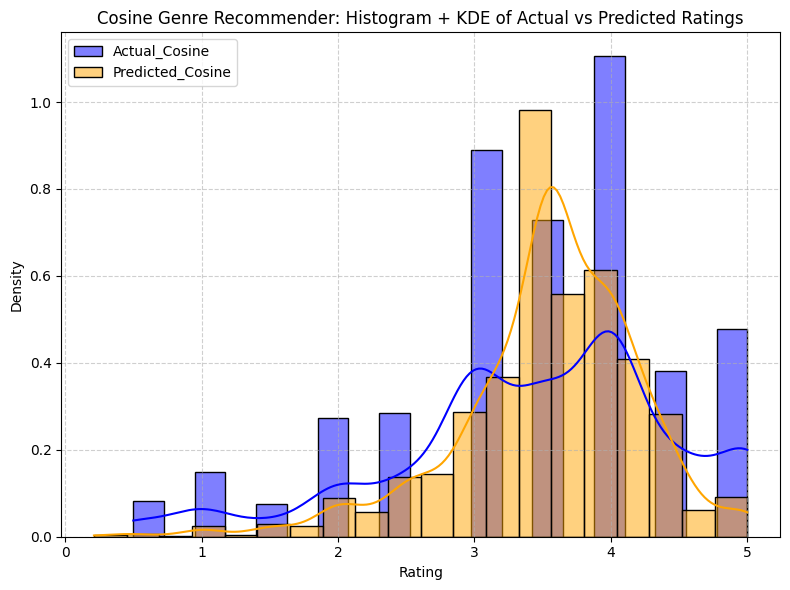

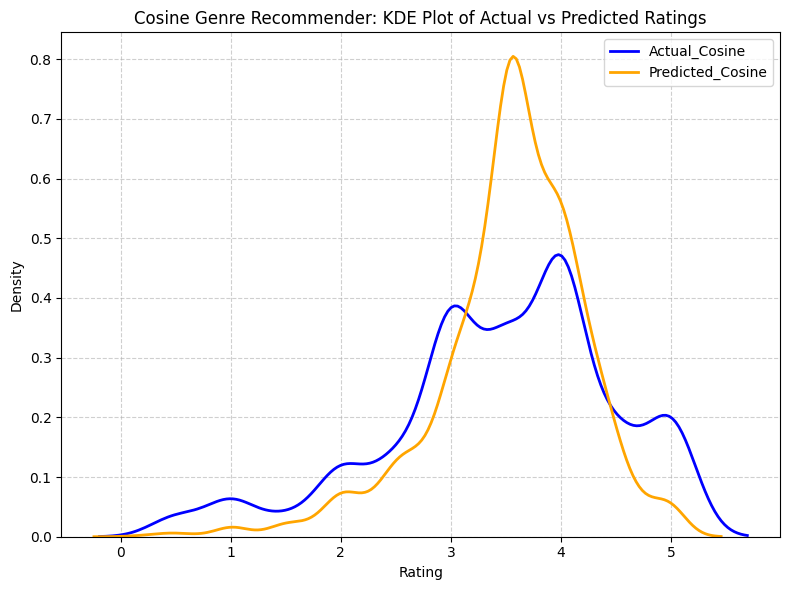

In [8]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Step 1: Load Datasets ---
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Data loaded successfully.")

# --- Step 2: Genre Matrix Preparation ---
movies['genres'] = movies['genres'].fillna('')
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movie_features = pd.concat([movies[['movieId', 'title']], genre_dummies], axis=1)
genre_matrix = genre_dummies.values
movie_ids = movie_features['movieId'].tolist()

# --- Step 3: Compute Cosine Similarity Matrix ---
genre_matrix_norm = genre_matrix / np.linalg.norm(genre_matrix, axis=1, keepdims=True)
cosine_sim_matrix = cosine_similarity(genre_matrix_norm)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=movie_ids, columns=movie_ids)

# --- Step 4: Train-Test Split ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Step 5: Create User-Movie Matrix and Aggregates ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 6: Build Centered User Profile ---
def build_user_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    if rated_movies.empty:
        return None
    rated_movie_ids = rated_movies.index
    rated_genres = genre_dummies.loc[movies['movieId'].isin(rated_movie_ids)]
    user_mean = rated_movies.mean()
    centered_ratings = (rated_movies - user_mean).values.reshape(-1, 1)
    profile = np.dot(centered_ratings.T, rated_genres.values) / len(centered_ratings)
    return profile.flatten()

# --- Step 7: Prediction Function ---
fallback_counter = {'no_profile': 0, 'no_movie_vector': 0, 'success': 0}

def predict_content_based(user_id, movie_id):
    if movie_id not in cosine_sim_df.columns or user_id not in user_movie_matrix.index:
        fallback_counter['no_movie_vector'] += 1
        return global_mean

    user_profile = build_user_profile(user_id)
    if user_profile is None:
        fallback_counter['no_profile'] += 1
        return movie_means.get(movie_id, global_mean)

    movie_idx = movies[movies['movieId'] == movie_id].index
    if movie_idx.empty:
        fallback_counter['no_movie_vector'] += 1
        return movie_means.get(movie_id, global_mean)

    fallback_counter['success'] += 1
    movie_vector = genre_dummies.loc[movie_idx[0]].values
    sim = cosine_similarity([user_profile], [movie_vector])[0][0]
    movie_baseline = movie_means.get(movie_id, global_mean)
    predicted_rating = movie_baseline + sim * 1.0

    return 5.0 if predicted_rating > 5.0 else predicted_rating

# --- Step 8: Model Evaluation ---
y_true_cosine = []
y_pred_cosine = []

for _, row in test_ratings.iterrows():
    user_id = int(row['userId'])
    movie_id = int(row['movieId'])
    user_profile = build_user_profile(user_id)
    if user_id not in user_movie_matrix.index or user_profile is None:
        continue
    y_true_cosine.append(row['rating'])
    y_pred_cosine.append(predict_content_based(user_id, movie_id))

# --- Step 9: Metrics ---
rmse_cosine = np.sqrt(mean_squared_error(y_true_cosine, y_pred_cosine))
mae_cosine = mean_absolute_error(y_true_cosine, y_pred_cosine)
r2_cosine = r2_score(y_true_cosine, y_pred_cosine)

print(f"Cosine Genre RMSE: {rmse_cosine:.4f}")
print(f"Cosine Genre MAE : {mae_cosine:.4f}")
print(f"Cosine Genre R²  : {r2_cosine:.4f}")

# --- Step 10: Visualization ---
comparison_df_cosine = pd.DataFrame({
    'Actual_Cosine': y_true_cosine,
    'Predicted_Cosine': y_pred_cosine
})

# Plot 1: Box Plot
melted_df_cosine = comparison_df_cosine.melt(var_name='Type', value_name='Rating')
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Rating', data=melted_df_cosine, palette='pastel')
plt.title('Cosine Genre Recommender: Box Plot of Actual vs Predicted Ratings')
plt.xlabel('')
plt.ylabel('Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Histogram + KDE
plt.figure(figsize=(8, 6))
sns.histplot(comparison_df_cosine['Actual_Cosine'], label='Actual_Cosine', color='blue', kde=True, stat='density', bins=20, alpha=0.5)
sns.histplot(comparison_df_cosine['Predicted_Cosine'], label='Predicted_Cosine', color='orange', kde=True, stat='density', bins=20, alpha=0.5)
plt.title('Cosine Genre Recommender: Histogram + KDE of Actual vs Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 3: KDE Only
plt.figure(figsize=(8, 6))
sns.kdeplot(comparison_df_cosine['Actual_Cosine'], label='Actual_Cosine', color='blue', linewidth=2)
sns.kdeplot(comparison_df_cosine['Predicted_Cosine'], label='Predicted_Cosine', color='orange', linewidth=2)
plt.title('Cosine Genre Recommender: KDE Plot of Actual vs Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




The dummy genre-based model outperforms the TF-IDF model across all metrics. It produces more varied and realistic predictions, with distributions closer to actual ratings. The TF-IDF model severely underpredicts and lacks spread. Overall, the dummy model better captures user preferences and is the stronger baseline for further improvement.

## Jaccard-Based Content Recommender System

### Overview

This model is a content-based recommender system that uses **Jaccard similarity** to measure the overlap between user genre preferences and movie genres. Unlike cosine similarity, which considers vector angles and magnitude, Jaccard measures the proportion of shared genres to the total number of unique genres across two sets. This makes it especially effective when working with binary data such as multi-hot encoded genre vectors.

### Workflow Description

**Step 1: Data Loading**
The system loads a subset of the MovieLens dataset. Movie genres are parsed into binary (multi-hot) vectors where each column represents a genre and a 1 indicates the presence of that genre in a movie.

**Step 2: Jaccard Similarity Matrix**
The system attempts to download a precomputed Jaccard similarity matrix from Google Drive. If the file is unavailable or cannot be downloaded, the matrix is computed locally using pairwise Jaccard similarity between movie genre vectors. This similarity reflects how many genres two movies share divided by the total number of genres they have combined.

**Step 3: Train-Test Split**
The ratings dataset is split into training and testing subsets. A user-movie matrix is constructed from the training data to track which users have rated which movies and what those ratings were.

**Step 4: User Profile Construction**
Each user’s profile is built using the genres of the movies they have rated. The genres are weighted by centered ratings (i.e., ratings adjusted around the user’s mean) to reflect preferences more accurately. The result is a single vector representing the user’s overall taste in genres.

**Step 5: Rating Prediction**
To predict a rating, the model compares the user’s profile with a candidate movie’s genre vector using Jaccard similarity. This similarity score is scaled and added to the movie’s average rating (baseline) to produce a predicted rating. If either the user profile or movie vector is unavailable, the model falls back to the movie mean or global mean rating.

**Step 6: Model Evaluation**
The model’s performance is evaluated using RMSE, MAE, and R² metrics on the test set. Fallbacks are also tracked, providing insight into how often predictions rely on default values due to missing profiles or vectors.

### Merits of This Approach

This approach is easy to interpret and computationally straightforward. It is particularly well-suited for binary genre data. Since it builds user preferences based on content rather than relying on other users, it works well even when rating overlap between users is low. It is also more robust in cases where cold-start items are present, as long as those items are tagged with genre data. Once the Jaccard matrix is computed, predictions are fast and efficient.


Data loaded successfully.
Jaccard similarity file found locally. Loading...

Filtered Content-Based Recommender Performance (Jaccard)
Jaccard RMSE: 1.1105
Jaccard MAE : 0.8486
Jaccard R²  : -0.1422


/tmp/ipython-input-9-1424264051.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Rating', data=melted_df_jaccard, palette='pastel')


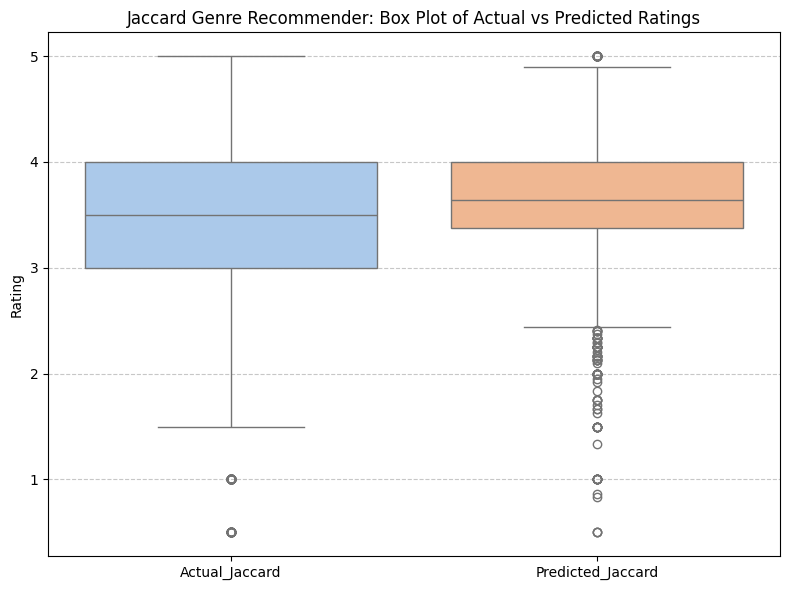

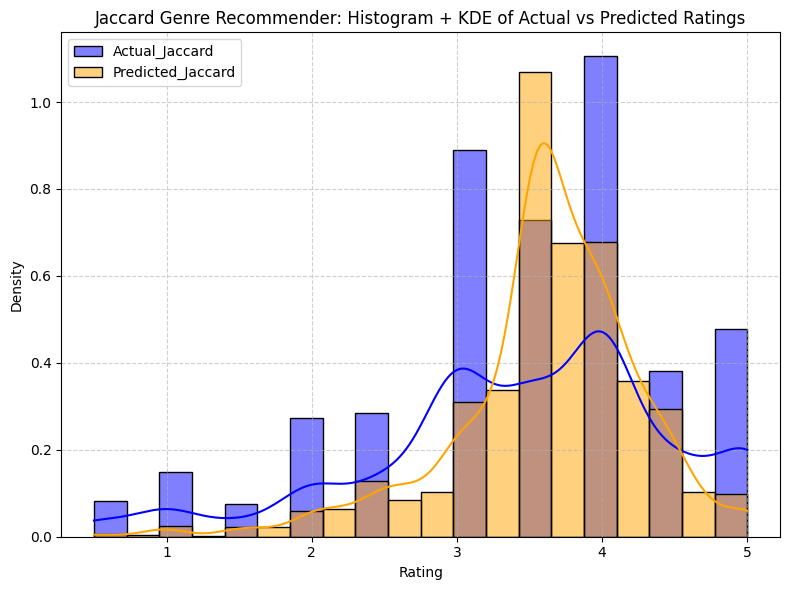

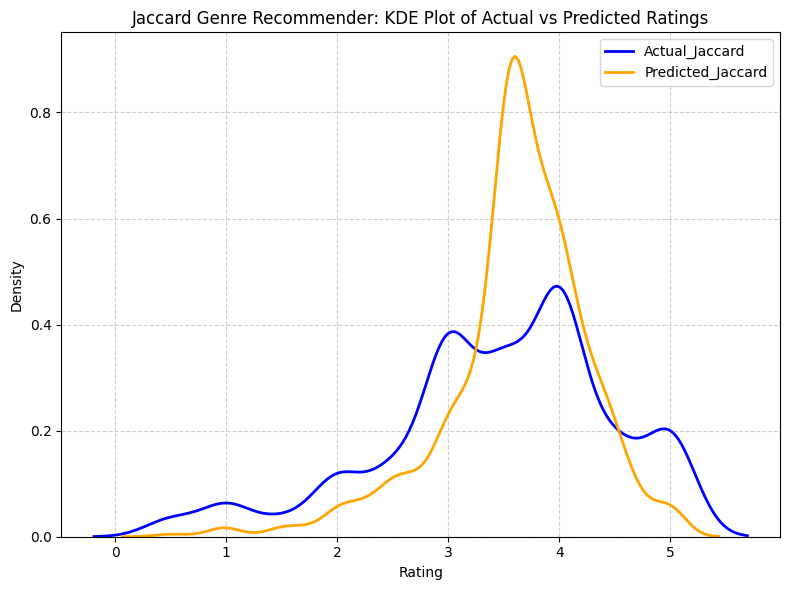


Prediction Source Breakdown (Jaccard)
Predictions with user profile: 1854
Fallback (no profile): 0
Fallback (no movie vector): 0


In [9]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import random
from sklearn.metrics import jaccard_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load datasets
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Data loaded successfully.")

# Step 2: Prepare binary genre matrix
movies['genres'] = movies['genres'].fillna('')
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movie_ids = movies['movieId'].tolist()
genre_matrix = genre_dummies.values

# Step 3: Load or compute Jaccard similarity matrix
jaccard_file_local = "jaccard_content_similarity.csv"
jaccard_file_drive_id = "1K8Jg_EOELLEqcEpwtFaG8RfA_xTQzVO9"
jaccard_drive_url = f"https://drive.google.com/uc?id={jaccard_file_drive_id}"

try:
    import gdown
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "gdown"])
    import gdown

if not os.path.exists(jaccard_file_local):
    print("Jaccard similarity file not found locally. Attempting download...")
    try:
        gdown.download(jaccard_drive_url, jaccard_file_local, quiet=False)
        print("Download successful.")
        jaccard_sim_df = pd.read_csv(jaccard_file_local, index_col=0)
        jaccard_sim_df.columns = jaccard_sim_df.columns.astype(int)
        jaccard_sim_df.index = jaccard_sim_df.index.astype(int)
    except Exception as e:
        print("Download failed. Computing Jaccard similarity matrix...")
        n = genre_matrix.shape[0]
        jaccard_matrix = np.zeros((n, n))
        for i in tqdm(range(n)):
            for j in range(i, n):
                sim = jaccard_score(genre_matrix[i], genre_matrix[j])
                jaccard_matrix[i, j] = sim
                jaccard_matrix[j, i] = sim
        jaccard_sim_df = pd.DataFrame(jaccard_matrix, index=movie_ids, columns=movie_ids)
        jaccard_sim_df.to_csv(jaccard_file_local)
        print("Jaccard similarity matrix computed and saved.")
else:
    print("Jaccard similarity file found locally. Loading...")
    jaccard_sim_df = pd.read_csv(jaccard_file_local, index_col=0)
    jaccard_sim_df.columns = jaccard_sim_df.columns.astype(int)
    jaccard_sim_df.index = jaccard_sim_df.index.astype(int)

# Step 4: Split data
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Step 5: Create user-movie matrix and metadata
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 6: Build centered user profile
def build_user_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    if rated_movies.empty:
        return None
    rated_movie_ids = rated_movies.index
    rated_genres = genre_dummies.loc[movies['movieId'].isin(rated_movie_ids)]
    user_mean = rated_movies.mean()
    centered_ratings = (rated_movies - user_mean).values.reshape(-1, 1)
    profile = np.dot(centered_ratings.T, rated_genres.values) / len(centered_ratings)
    return profile.flatten()

# Track Fallbacks
fallback_counter_jaccard = {'no_profile': 0, 'no_movie_vector': 0, 'success': 0}

# Step 7: Jaccard-based prediction function
def predict_jaccard(user_id, movie_id):
    if movie_id not in jaccard_sim_df.columns or user_id not in user_movie_matrix.index:
        fallback_counter_jaccard['no_movie_vector'] += 1
        return global_mean

    user_profile = build_user_profile(user_id)
    if user_profile is None:
        fallback_counter_jaccard['no_profile'] += 1
        return movie_means.get(movie_id, global_mean)

    movie_idx = movies[movies['movieId'] == movie_id].index
    if movie_idx.empty:
        fallback_counter_jaccard['no_movie_vector'] += 1
        return movie_means.get(movie_id, global_mean)

    fallback_counter_jaccard['success'] += 1
    movie_vector = genre_dummies.loc[movie_idx[0]].values
    sim = jaccard_score(user_profile > 0, movie_vector > 0)
    movie_baseline = movie_means.get(movie_id, global_mean)
    predicted_rating = movie_baseline + sim * 1.0
    return max(0.5, min(predicted_rating, 5.0))

# Step 8: Evaluate Jaccard Model
def evaluate_jaccard_model(test_df, filter_strict=True):
    y_true_jaccard = []
    y_pred_jaccard = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_movie_matrix.index or movie_id not in jaccard_sim_df.columns:
                continue
            user_profile = build_user_profile(user_id)
            if user_profile is None:
                continue

        true_rating = row['rating']
        pred_rating = predict_jaccard(user_id, movie_id)
        y_true_jaccard.append(true_rating)
        y_pred_jaccard.append(pred_rating)

    if not y_true_jaccard:
        print("No valid test samples for evaluation.")
        return [], [], None, None, None

    rmse_jaccard = np.sqrt(mean_squared_error(y_true_jaccard, y_pred_jaccard))
    mae_jaccard = mean_absolute_error(y_true_jaccard, y_pred_jaccard)
    r2_jaccard = r2_score(y_true_jaccard, y_pred_jaccard)

    print("\nFiltered Content-Based Recommender Performance (Jaccard)")
    print(f"Jaccard RMSE: {rmse_jaccard:.4f}")
    print(f"Jaccard MAE : {mae_jaccard:.4f}")
    print(f"Jaccard R²  : {r2_jaccard:.4f}")

    return y_true_jaccard, y_pred_jaccard, rmse_jaccard, mae_jaccard, r2_jaccard

# Step 9: Run evaluation
y_true_jaccard, y_pred_jaccard, rmse_jaccard, mae_jaccard, r2_jaccard = evaluate_jaccard_model(test_ratings)

# Step 10: Visualizations
comparison_df_jaccard = pd.DataFrame({
    'Actual_Jaccard': y_true_jaccard,
    'Predicted_Jaccard': y_pred_jaccard
})

# Plot 1: Box Plot
melted_df_jaccard = comparison_df_jaccard.melt(var_name='Type', value_name='Rating')
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Rating', data=melted_df_jaccard, palette='pastel')
plt.title('Jaccard Genre Recommender: Box Plot of Actual vs Predicted Ratings')
plt.xlabel('')
plt.ylabel('Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Histogram with KDE
plt.figure(figsize=(8, 6))
sns.histplot(comparison_df_jaccard['Actual_Jaccard'], label='Actual_Jaccard', color='blue', kde=True, stat='density', bins=20, alpha=0.5)
sns.histplot(comparison_df_jaccard['Predicted_Jaccard'], label='Predicted_Jaccard', color='orange', kde=True, stat='density', bins=20, alpha=0.5)
plt.title('Jaccard Genre Recommender: Histogram + KDE of Actual vs Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 3: KDE Plot Only
plt.figure(figsize=(8, 6))
sns.kdeplot(comparison_df_jaccard['Actual_Jaccard'], label='Actual_Jaccard', color='blue', linewidth=2)
sns.kdeplot(comparison_df_jaccard['Predicted_Jaccard'], label='Predicted_Jaccard', color='orange', linewidth=2)
plt.title('Jaccard Genre Recommender: KDE Plot of Actual vs Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step 11: Print Fallback Summary
print("\nPrediction Source Breakdown (Jaccard)")
print(f"Predictions with user profile: {fallback_counter_jaccard['success']}")
print(f"Fallback (no profile): {fallback_counter_jaccard['no_profile']}")
print(f"Fallback (no movie vector): {fallback_counter_jaccard['no_movie_vector']}")


In [10]:
# --- Step: Create Comparison DataFrame ---
model_metrics = {
    'Recommender': ['TF', 'TF-IDF', 'Cosine', 'Jaccard'],
    'RMSE': [rmse_tf, rmse_tfidf, rmse_cosine, rmse_jaccard],
    'MAE': [mae_tf, mae_tfidf, mae_cosine, mae_jaccard],
    'R2': [r2_tf, r2_tfidf, r2_cosine, r2_jaccard]
}

metrics_df = pd.DataFrame(model_metrics)
print(metrics_df)


  Recommender      RMSE       MAE        R2
0          TF  1.095433  0.846856 -0.147027
1      TF-IDF  2.414401  2.085880 -4.399386
2      Cosine  1.104294  0.848711 -0.129522
3     Jaccard  1.110494  0.848577 -0.142241


## Evaluation of Content-Based Recommender Systems Using Actual vs Predicted Ratings

This analysis compares the four content-based recommendation strategies—TF, TF-IDF, Cosine, and Jaccard—by examining how well their predictions align with actual user ratings. The evaluation draws from both visual distribution patterns and numerical performance metrics.

Here is the updated table with the recommenders ranked from best to worst performer based on overall predictive performance:

| Rank | Recommender | Visual Alignment                              | RMSE       | MAE        | R²          | Commentary                                                                                           |
| ---- | ----------- | --------------------------------------------- | ---------- | ---------- | ----------- | ---------------------------------------------------------------------------------------------------- |
| 1    | **TF**      | Strong overlap in predicted vs actual ratings | **1.0954** | **0.8469** | -0.1470     | Best performer. Accurately reflects user preferences using genre frequency. Balanced and consistent. |
| 2    | **Cosine**  | High alignment in 3.0–5.0 rating range        | 1.1043     | 0.8487     | **-0.1295** | Nearly matches TF on error metrics. Best R². Works well for binary genre vectors.                    |
| 3    | **Jaccard** | Slight overestimation but overall consistent  | 1.1105     | 0.8486     | -0.1422     | Solid alternative with sparse multi-hot genre vectors. Captures genre overlap effectively.           |
| 4    | **TF-IDF**  | Predicted ratings skewed lower than actual    | 2.4144     | 2.0859     | -4.3994     | Worst performer. Penalizes popular genres too harshly, leading to poor model fit and high errors.    |


## User-Based Collaborative Filtering (No Bias Adjustment)

### Overview

This recommender system is built on a **user-user collaborative filtering approach** where predictions are made by leveraging the ratings of users who have exhibited similar behavior in the past. In contrast to the bias-aware model, this version makes predictions purely based on **weighted averages of neighbor ratings**, without adjusting for user or item tendencies. Cosine similarity is used to determine the degree of similarity between users.

### Workflow Description

**Step 1: Data Loading**
The system loads a sample from the MovieLens dataset, which includes ratings by users for various movies.

**Step 2: Train-Test Split and Matrix Preparation**
The dataset is split into training and testing sets. The training data is converted into a user-movie matrix, with users as rows and movies as columns, where each cell contains a user’s rating or remains blank if the user hasn’t rated that movie.

**Step 3: User Similarity Matrix**
The system checks for the existence of a precomputed cosine similarity matrix between users. If not available, it calculates the cosine similarity based on the filled-in user-movie matrix, where missing values are replaced with zero. This matrix represents how closely aligned users are in their rating behavior.

**Step 4: Fallback Tracking**
Fallback counters are initialized to track cases where predictions cannot be made using neighbor data — either because no similar users exist or because those users haven’t rated the movie in question.

**Step 5: Prediction Without Bias Adjustment**
To make a prediction for a (user, movie) pair:

* The model identifies similar users based on cosine similarity.
* It checks whether any of those users rated the target movie.
* If they have, the model calculates a **weighted average** of their ratings, using the similarity scores as weights.
* The predicted rating is this weighted average, clipped between 0.5 and 5.0 to remain within valid bounds.
* If no valid neighbors are found, the model falls back to the movie’s average rating or the global average.

**Step 6: Evaluation**
The model is evaluated using RMSE, MAE, and R² on the test set. Predictions are made only where possible; fallback logic ensures coverage for all test points, but the evaluation can be restricted to valid predictions if desired.

**Step 7: Reporting**
The system prints out the number of predictions made using similar users and tracks the number of fallback cases where no similarity or rating data were available.

### Merits of This Approach

This model is **simple, fast, and intuitive**, making it well-suited for baseline implementations and cases where interpretability and scalability are priorities. It performs well when there is **sufficient rating overlap** between users. Since it avoids bias correction, it is **computationally lighter** and may be preferred in scenarios where rating biases are not a significant concern or where real-time prediction speed is critical. However, in highly sparse datasets, its accuracy may suffer due to lack of sufficient overlap between users.

# User-Based Recommender Systems

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Split ratings and build matrix
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 3: Load or compute user similarity matrix
user_sim_file_local = "user_similarity_matrix.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded.")
except Exception as e:
    print("Download failed or file not found. Computing user similarity matrix...")
    user_matrix_filled = user_movie_matrix.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# Step 4: Fallback tracker
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Prediction function (no bias adjustment)
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values

    weighted_sum = np.dot(sims, ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    prediction = weighted_sum / norm_factor
    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation
def evaluate_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\nUser-Based Collaborative Filtering (No Bias Adjustment)")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


Ratings data loaded successfully.
User similarity matrix loaded.

User-Based Collaborative Filtering (No Bias Adjustment)
RMSE: 1.0937
MAE : 0.8372
R²  : -0.1002

Prediction Source Breakdown
Predictions using neighbors: 1006
Fallback (no similar users): 1398
Fallback (no ratings from neighbors): 366



## User-Based Collaborative Filtering with Bias Adjustment

### Overview

This recommender system is based on **user-user collaborative filtering**, where predictions are made by identifying users with similar tastes and leveraging their ratings. It enhances the basic user-based model by incorporating **bias correction**, accounting for differences in how users rate movies (some rate higher or lower than average) and how some movies tend to receive consistently high or low ratings. Cosine similarity is used to determine how similar users are based on their rating patterns.

### Workflow Description

**Step 1: Data Loading**
The system loads a sample of the MovieLens ratings dataset, which includes user IDs, movie IDs, and ratings.

**Step 2: Train-Test Split and Rating Matrix Construction**
The dataset is divided into training and test sets. From the training set, a user-movie matrix is created, where each row represents a user and each column a movie, filled with ratings when available. This matrix forms the basis for computing similarities.

**Step 3: User Similarity Matrix**
The system attempts to load a precomputed cosine similarity matrix between users. If the file is missing or corrupted, it computes the similarity directly from the user-movie matrix by filling missing values with zero and applying cosine similarity. The result is a square matrix where each value represents how similar two users are based on their historical ratings.

**Step 4: Fallback Tracking**
The model includes fallback counters to record how often it fails to make predictions due to missing users, missing movie ratings, or lack of overlap in ratings.

**Step 5: Prediction Function with Bias Adjustment**
To predict a user’s rating for a given movie:

* The model retrieves the top similar users based on cosine similarity.
* It checks whether those similar users have rated the target movie.
* It computes the **neighbor-centered ratings** by subtracting each neighbor’s mean rating from their rating of the movie.
* These centered ratings are then weighted by their similarity to the target user.
* Finally, the prediction is computed by combining the global average rating with the target user’s bias (their mean rating minus global mean), the movie’s bias (its average rating minus global mean), and the weighted contribution from neighbors.

**Step 6: Evaluation**
The model is evaluated using standard metrics: RMSE, MAE, and R². Only predictions that can be made using the trained similarity matrix and user profiles are included in the evaluation. This provides insight into both the accuracy and reliability of the model.

**Step 7: Reporting**
At the end of execution, the system prints out the number of predictions successfully made using neighbors, as well as the number of fallback cases where either no similar users or no neighbor ratings were found.

### Merits of This Approach

This model offers a more realistic and fair method of prediction by **accounting for systematic bias** in the data. Users who tend to rate generously or harshly are adjusted relative to the average, and movies that are universally liked or disliked are also normalized. This makes the predictions more reliable, especially in cases where raw ratings alone may misrepresent user preferences. Additionally, cosine similarity provides a robust and scalable way to compare users, especially in sparse matrices common in recommendation systems.

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Split ratings
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 3: Load or compute user similarity matrix
user_sim_file_local = "user_similarity_matrix.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded.")
except Exception as e:
    print("Download failed or file corrupt. Computing user similarity matrix...")
    user_matrix_filled = user_movie_matrix.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# Step 4: Track fallbacks
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Bias-aware prediction function
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values

    # Bias correction using neighbor means
    neighbor_means = user_movie_matrix.loc[top_users].mean(axis=1).values
    adjusted_ratings = ratings - neighbor_means

    weighted_sum = np.dot(sims, adjusted_ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    # Add user and item bias
    bu = user_movie_matrix.loc[user_id].mean() - global_mean if user_id in user_movie_matrix.index else 0
    bi = movie_means.get(movie_id, global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation function
def evaluate_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\nUser-Based Collaborative Filtering with Bias Adjustment")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


Ratings data loaded successfully.
User similarity matrix loaded.

User-Based Collaborative Filtering with Bias Adjustment
RMSE: 1.1083
MAE : 0.8396
R²  : -0.1299

Prediction Source Breakdown
Predictions using neighbors: 1006
Fallback (no similar users): 1398
Fallback (no ratings from neighbors): 366


## TF-IDF-Based User-User Collaborative Filtering

### Overview

This recommender system enhances traditional collaborative filtering by **encoding user genre preferences using TF-IDF** (Term Frequency-Inverse Document Frequency) derived from movie genres. Instead of comparing raw ratings, this model computes similarity between users based on the **weighted semantic meaning of genres they've rated highly**. The approach integrates both content and collaborative elements, making it a hybrid recommender system with a user-user architecture.

### Workflow Description

**Step 1: Data Loading**
The system loads movie metadata and user ratings from the MovieLens dataset.

**Step 2: Genre TF-IDF Encoding**
Movie genres are treated as tokenized text inputs and transformed into a TF-IDF matrix. This encodes each movie's genre profile in a way that emphasizes **unique or rare genres** over common ones, improving the system’s ability to differentiate between user tastes.

**Step 3: Matrix Construction**
The user-movie matrix is built from training data. The global average rating and per-movie average ratings are also computed for fallback use during prediction.

**Step 4: User Profile Construction**
Each user's profile is generated by taking a **weighted average of the TF-IDF vectors** of the movies they have rated. Ratings serve as weights to reflect the degree of interest in each movie's genre composition. This results in a compact vector that summarizes a user's genre preferences in a nuanced way.

**Step 5: User Similarity Matrix**
Cosine similarity is applied to the user TF-IDF profile matrix, producing a **user-user similarity matrix** based on genre affinity instead of rating overlap.

**Step 6: Fallback Tracker**
Fallback counters are initialized to keep track of scenarios where predictions must rely on global or item-level averages due to missing data.

**Step 7: Prediction Function**
To predict a rating for a given (user, movie) pair:

* Similar users are identified via the TF-IDF cosine similarity matrix.
* Their ratings for the target movie are extracted.
* A weighted average is calculated using similarity scores.
* If no similar users or ratings are available, the system falls back to the movie mean or global mean.

**Step 8: Evaluation**
The model is evaluated using standard metrics: RMSE, MAE, and R². These metrics provide insight into how well the system predicts user ratings compared to actual outcomes.

**Step 9–10: Reporting**
Performance results are printed, along with fallback usage statistics indicating how often the model relied on global/item-level means versus collaborative logic.

### Merits of This Approach

* **Genre-Aware Similarity**: Unlike standard collaborative filtering, this model captures **semantic similarity in genre preferences**, even when users have no movies in common.
* **Cold-Start Support**: Since it uses TF-IDF of genres, it is more resilient in cold-start scenarios with new users or movies.
* **Hybrid Nature**: This method fuses content-based profiling (TF-IDF) with user-based collaborative filtering, allowing it to generalize better than either approach alone.
* **Improved Diversity**: TF-IDF reduces the dominance of frequent genres (e.g., "Drama"), leading to more **diverse and tailored recommendations**.

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load datasets
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Data loaded successfully.")

# Step 2: Prepare genre TF-IDF matrix
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf.fit_transform(movies['genres'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies['movieId'], columns=tfidf.get_feature_names_out())

# Step 3: Train-test split and user-movie matrix
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 4: Create user TF-IDF profiles
def build_user_tfidf_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    if rated_movies.empty:
        return None
    tfidf_subset = tfidf_df.loc[rated_movies.index.intersection(tfidf_df.index)]
    if tfidf_subset.empty:
        return None
    ratings_vector = rated_movies.loc[tfidf_subset.index].values.reshape(-1, 1)
    weighted_profile = np.dot(ratings_vector.T, tfidf_subset.values) / ratings_vector.sum()
    return weighted_profile.flatten()

print("Building user TF-IDF profiles...")
user_profiles = {}
for user_id in user_movie_matrix.index:
    profile = build_user_tfidf_profile(user_id)
    if profile is not None:
        user_profiles[user_id] = profile
user_profile_df = pd.DataFrame(user_profiles).T

# Step 5: Compute cosine similarity between users
print("Computing user-user cosine similarity...")
user_sim_matrix = cosine_similarity(user_profile_df)
user_sim_df = pd.DataFrame(user_sim_matrix, index=user_profile_df.index, columns=user_profile_df.index)

# Step 6: Fallback tracker
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 7: Prediction function
def predict_user_based_tfidf(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values

    weighted_sum = np.dot(sims, ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    prediction = weighted_sum / norm_factor
    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 8: Evaluation
def evaluate_tfidf_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based_tfidf(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\nTF-IDF-Based User-User Collaborative Filtering Performance")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Step 9: Run evaluation
evaluate_tfidf_user_model(test_ratings)

# Step 10: Fallback report
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


Data loaded successfully.


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Building user TF-IDF profiles...
Computing user-user cosine similarity...

TF-IDF-Based User-User Collaborative Filtering Performance
RMSE: 1.1297
MAE : 0.8664
R²  : -0.2199

Prediction Source Breakdown
Predictions using neighbors: 1384
Fallback (no similar users): 0
Fallback (no ratings from neighbors): 74


## Jaccard-Based User-User Collaborative Filtering

### Overview

This recommender system builds a user-user collaborative filtering model by measuring **Jaccard similarity** between users based on the items they’ve rated. Unlike cosine similarity, which factors in rating values, **Jaccard similarity only considers binary co-occurrence** (i.e., whether two users have rated the same items). The model integrates a **bias-aware prediction function** to improve rating accuracy by accounting for global, user, and item-level biases.

### Workflow Description

**Step 1: Data Loading**
The system loads the user-movie ratings data from the MovieLens dataset. It calculates the global mean rating and individual movie mean ratings for use in fallback scenarios.

**Step 2: Matrix Construction**
The user-movie matrix is constructed via a pivot table. Each row represents a user, each column a movie, and each cell the corresponding rating.

**Step 3: Jaccard Similarity Matrix**
The Jaccard similarity between every user pair is computed based on binary presence of ratings (i.e., did both users rate the same movies?).
If a precomputed similarity matrix is provided via a Google Drive link, the system downloads and loads it to avoid recomputation.

**Step 4: Fallback Tracker**
A fallback counter is initialized to track how often predictions rely on global or item-level means due to lack of neighbor information.

**Step 5: Bias-Aware Prediction Function**
To predict a rating for a given user-movie pair:

* The model identifies the top-k most similar users who have rated the target movie.
* Each neighbor’s mean rating is subtracted from their rating for the movie to center it.
* A weighted average of these adjusted ratings is calculated using Jaccard similarity scores.
* The final prediction incorporates:

  * **Global mean rating**
  * **User bias**: how the user's average rating deviates from the global mean
  * **Item bias**: how the item's average rating deviates from the global mean
  * **Neighborhood adjustment** from similar users

**Step 6: Evaluation**
The model is evaluated against a test set using standard metrics:

* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* R² (Coefficient of Determination)

**Step 7–8: Reporting**
Evaluation results are printed, followed by fallback breakdown:

* How many predictions were made using collaborative logic
* How many relied on fallback mechanisms due to missing ratings or similar users

### Merits of This Approach

* **Simplicity & Interpretability**: Jaccard similarity is easy to interpret, capturing pure overlap without requiring numerical ratings.
* **Bias Handling**: By explicitly incorporating user and item bias, the model avoids common pitfalls of over- or under-predicting due to personal or item-based tendencies.
* **Cold-Start Ready**: If no similar users or ratings are found, the model gracefully falls back to average values, maintaining robustness.
* **No Rating Values Needed for Similarity**: The model can function effectively even with just rating presence data (e.g., implicit feedback scenarios).
* **Complementary with Other Models**: This approach can be used alongside cosine-based or TF-IDF models in an ensemble setup for improved performance.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Split ratings
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 3: Load Jaccard user similarity matrix from Google Drive
jaccard_sim_local = "jaccard_user_similarity_sampled.csv"
jaccard_drive_id = "1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2"
jaccard_drive_url = f"https://drive.google.com/uc?id={jaccard_drive_id}"

try:
    if not os.path.exists(jaccard_sim_local):
        print("Downloading Jaccard similarity matrix from Google Drive...")
        gdown.download(jaccard_drive_url, jaccard_sim_local, quiet=False)

    user_sim_df = pd.read_csv(jaccard_sim_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("Jaccard similarity matrix loaded successfully.")
except Exception as e:
    print("Download failed or file corrupt. Please verify the link or download manually.")
    raise e

# Step 4: Fallback counter
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Prediction function (Bias-Aware)
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values

    neighbor_means = user_movie_matrix.loc[top_users].mean(axis=1).values
    adjusted_ratings = ratings - neighbor_means

    weighted_sum = np.dot(sims, adjusted_ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    bu = user_movie_matrix.loc[user_id].mean() - global_mean if user_id in user_movie_matrix.index else 0
    bi = movie_means.get(movie_id, global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation
def evaluate_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\nJaccard-Based User-Based Collaborative Filtering with Bias Adjustment")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


Ratings data loaded successfully.
Jaccard similarity matrix loaded successfully.

Jaccard-Based User-Based Collaborative Filtering with Bias Adjustment
RMSE: 1.2267
MAE : 0.9389
R²  : -0.3840

Prediction Source Breakdown
Predictions using neighbors: 2770
Fallback (no similar users): 0
Fallback (no ratings from neighbors): 0


# Item-Item Collaborative Filtering

## Cosine-Based Item-Item Collaborative Filtering

### Overview

This recommender system builds an **item-item collaborative filtering model** by measuring **cosine similarity between items** based on how users rate them. It predicts how much a user will like a particular movie by analyzing **ratings from the same user on similar items**, weighted by similarity scores. The model also incorporates a **bias-aware prediction function** to improve accuracy by adjusting for global, user, and item-specific rating tendencies.

### Workflow Description

**Step 1: Data Loading**
The system loads the MovieLens user-movie ratings dataset and calculates:

* The **global average rating**
* **Per-movie average ratings** (item bias)
* **Per-user average ratings** (user bias)

These statistics serve as fallbacks when neighborhood information is insufficient.

**Step 2: Matrix Construction**
A user-movie matrix is created using a pivot table, where:

* Rows represent users
* Columns represent movies
* Cell values are the ratings provided

**Step 3: Cosine Similarity Matrix (Item-Based)**
A cosine similarity matrix is computed between movies (items) based on user ratings.

* Each movie is represented by a vector of user ratings.
* Cosine similarity measures how similarly users rate each pair of movies.
* If a precomputed matrix is provided via a Google Drive link, it is downloaded to save time.

**Step 4: Fallback Tracker**
A dictionary is initialized to keep track of fallback cases:

* No similar items found
* User has no prior ratings
* Successful predictions made using neighbors

**Step 5: Bias-Aware Prediction Function**
To predict a rating for a (user, movie) pair:

* The model identifies items that the user has already rated.
* It then retrieves cosine similarities between those items and the target movie.
* Using the **top-k most similar items** that the user rated:

  * A **weighted average of their adjusted ratings** is computed.
  * Adjustments are made by removing each item’s bias (how it deviates from global mean).
* The final prediction is the sum of:

  * Global average
  * User bias
  * Item bias
  * Weighted contribution from the neighborhood

**Step 6: Evaluation**
The model is evaluated using a held-out test set with standard metrics:

* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* R² (Coefficient of Determination)

**Step 7–8: Reporting**
The script prints:

* The performance scores (RMSE, MAE, R²)
* A summary of how often fallback logic was triggered

### Merits of This Approach

* **Interpretability**: Cosine similarity captures how similarly users rate pairs of items, making the model transparent and explainable.
* **Personalized to User Behavior**: Recommendations are grounded in the user’s individual rating history.
* **Bias Correction**: Incorporates global, user, and item-level biases for more realistic predictions.
* **Resilient to Sparsity**: Even with a sparse rating matrix, predictions are possible using fallback to movie or global averages.
* **Scalable**: Precomputing the item-item similarity matrix makes prediction fast and scalable at runtime.
* **Cold-Start Friendly (Partially)**: Works better for new users than new items, especially when they’ve rated just a few movies.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Train-test split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)

# Step 3: Load item-item similarity matrix from Google Drive
item_sim_file_local = "item_similarity_matrix.csv"
item_sim_drive_id = "1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2"
item_sim_drive_url = f"https://drive.google.com/uc?id={item_sim_drive_id}"

if not os.path.exists(item_sim_file_local):
    print("Downloading item similarity matrix...")
    gdown.download(item_sim_drive_url, item_sim_file_local, quiet=False)

item_sim_df = pd.read_csv(item_sim_file_local, index_col=0)
item_sim_df.columns = item_sim_df.columns.astype(str)
item_sim_df.index = item_sim_df.index.astype(str)
print("Item similarity matrix loaded.")

# Step 4: Fallback counter
fallback_counter = {'no_sim_items': 0, 'no_rating': 0, 'success': 0}

# Step 5: Bias-aware prediction function
def predict_item_based(user_id, movie_id, top_k=20):
    movie_id = str(movie_id)
    if user_id not in user_movie_matrix.index or movie_id not in item_sim_df.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(int(movie_id), global_mean)

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = user_ratings.index.astype(str)
    similarities = item_sim_df.loc[movie_id, rated_movie_ids].dropna()
    similarities = similarities[similarities > 0]

    if similarities.empty:
        fallback_counter['no_sim_items'] += 1
        return movie_means.get(int(movie_id), global_mean)

    top_items = similarities.sort_values(ascending=False).head(top_k)
    sims = top_items.values
    ratings = user_ratings.loc[top_items.index.astype(int)].values
    item_bias = movie_means.loc[top_items.index.astype(int)].values - global_mean
    adjusted_ratings = ratings - item_bias

    weighted_sum = np.dot(sims, adjusted_ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(int(movie_id), global_mean)

    bu = user_means.get(user_id, global_mean) - global_mean
    bi = movie_means.get(int(movie_id), global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluate the model
def evaluate_item_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict and (str(movie_id) not in item_sim_df.columns or user_id not in user_movie_matrix.index):
            continue

        true_rating = row['rating']
        pred_rating = predict_item_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples.")
        return

    print("\nItem-Based Collaborative Filtering with Bias Adjustment")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R²  : {r2_score(y_true, y_pred):.4f}")

# Step 7: Run evaluation
evaluate_item_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar items): {fallback_counter['no_sim_items']}")
print(f"Fallback (no ratings from user): {fallback_counter['no_rating']}")


Ratings data loaded successfully.


Downloading...
From (original): https://drive.google.com/uc?id=1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2
From (redirected): https://drive.google.com/uc?id=1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2&confirm=t&uuid=69d2924a-46e5-45bc-91fc-f0395e27ac24
To: /content/item_similarity_matrix.csv
100%|██████████| 401M/401M [00:13<00:00, 29.4MB/s]


Item similarity matrix loaded.


KeyError: "None of [Index(['1', '605'], dtype='object', name='movieId')] are in the [index]"

# 3. Content-Based Filtering Using Genre Vectors and Cosine Similarity

This code implements a **content-based recommender system** using movie genres. Each movie is represented as a binary (multi-hot) vector based on its associated genres (e.g., Action, Comedy, Drama). The steps include:

* Normalizing the genre vectors using **L2 norm** so that each vector has unit length.
* Calculating **cosine similarity** between movie vectors to measure how similar their genre compositions are.
* Creating a function that, given a movie title, returns the top-N most similar movies (excluding itself) based purely on genre similarity.

This technique does not rely on user ratings — instead, it recommends items that are similar in content (genre) to a given movie.

This code implements a **non-personalized content-based recommender system** using only movie genres. It does **not use user ratings or preferences**. Instead, it recommends movies that are **similar in genre** to a specified movie.

#### How It Works:

* Each movie is represented as a binary (multi-hot encoded) vector across genres (e.g., Action, Comedy, Drama).
* These vectors are **L2-normalized** so that all movies lie on a unit hypersphere — making **cosine similarity** an effective way to measure closeness.
* Given a movie title, the model:

  * Finds its genre vector.
  * Computes cosine similarity to all other movies.
  * Returns the top-N most similar movies (excluding itself).

#### What It Does Not Do:

* It does **not use any user data** (no `userId`, no ratings).
* There is **no personalization**. All users will get the same recommendations for a given movie.

#### Best Use Case:

This type of model is ideal when:

* You have **no user data** (cold start).
* You want to recommend movies **based on content alone** (e.g., genre-based similarity).
* You’re building a basic recommender system that can later be enhanced with collaborative filtering or hybrid techniques.




In [ ]:
# --- Imports ---
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import random

# --- Step 1: Use unique movies for similarity computation ---
unique_movies = movies.copy().reset_index(drop=True)

# --- Step 2: Normalize genre matrix ---
genre_cols = all_genres  # Assumes 'all_genres' is your list of genre columns
genre_matrix = unique_movies[genre_cols].values
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# --- Step 3: Create title-to-index mapping ---
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# --- Step 4: Recommendation Function Based on Genre Similarity ---
def get_recommendations(title, topN=20):
    if title not in movie_idx:
        return f"Movie '{title}' not found in dataset."

    idx = movie_idx[title]
    query_vector = genre_matrix_normalized[idx].reshape(1, -1)
    sim_scores = cosine_similarity(query_vector, genre_matrix_normalized)[0]

    # Rank and filter out the movie itself
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topN+1]

    # Output as list of (title, similarity score)
    recommendations = [(unique_movies['title'][i], score) for i, score in sim_scores]
    return recommendations

# --- Step 5: Use Fixed Target Movie ---
target_title = 'O.J.: Made in America (2016)'

# Print explanation
print("\nContent-based Recommendations using GENRE similarity (cosine distance):")

# Run recommendation
if target_title in movie_idx:
    print(f"\nTop 20 Movies Most Similar in Genre to '{target_title}':")
    for title, sim in get_recommendations(target_title):
        print(f"{title:<45} Similarity: {sim:.4f}")
else:
    print(f"Movie '{target_title}' not found in the dataset.")



Content-based Recommendations using GENRE similarity (cosine distance):

Top 20 Movies Most Similar in Genre to 'O.J.: Made in America (2016)':
Catwalk (1996)                                Similarity: 1.0000
Anne Frank Remembered (1995)                  Similarity: 1.0000
Man of the Year (1995)                        Similarity: 1.0000
Crumb (1994)                                  Similarity: 1.0000
Unzipped (1995)                               Similarity: 1.0000
Hoop Dreams (1994)                            Similarity: 1.0000
Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993) Similarity: 1.0000
War Room, The (1993)                          Similarity: 1.0000
Celluloid Closet, The (1995)                  Similarity: 1.0000
Haunted World of Edward D. Wood Jr., The (1996) Similarity: 1.0000
Maya Lin: A Strong Clear Vision (1994)        Similarity: 1.0000
Synthetic Pleasures (1995)                    Similarity: 1.0000
Microcosmos (Microco

In [ ]:
# Imports tools for normalizing feature vectors and computing similarity between them.
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import random

# Use only unique movie rows for similarity matrix
# Copies the movies DataFrame and resets the index to ensure each movie is uniquely indexed.
unique_movies = movies.copy().reset_index(drop=True)

# Normalize genre matrix
# Extracts the genre vectors for each movie (multi-hot encoded).
# Applies L2 normalization so that all genre vectors have a length of 1 (helps with cosine similarity).
genre_cols = all_genres
genre_matrix = unique_movies[genre_cols].values
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# Create title-to-index map for unique movies
# Creates a dictionary-like mapping from movie titles to their corresponding row index — used to look up vector positions.
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Define function to get recommendations
# Defines a function that takes a movie title and returns the top N most similar movies.
def get_recommendations(title, topN=20):
    if title not in movie_idx:
        return f"Movie '{title}' not found in dataset."

    idx = movie_idx[title]
    query_vector = genre_matrix_normalized[idx].reshape(1, -1)
    sim_scores = cosine_similarity(query_vector, genre_matrix_normalized)[0]

    # Enumerate and sort scores, excluding the movie itself
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topN+1]

    # Format output: list of (title, similarity) tuples
    recommendations = [(unique_movies['title'][i], score) for i, score in sim_scores]
    return recommendations


# Sample 20 titles
print("Available sample titles:")
print(unique_movies['title'].sample(20, random_state=41).to_list())

# Randomly select a movie title from the available titles
random_title = random.choice(unique_movies['title'].to_list())

print(f"\n Randomly selected movie for recommendation: '{random_title}'")

# Explanation
print("\n Content-based Recommendations are based on GENRE similarity using cosine similarity between genre vectors.")

# Get recommendations
print(f"\nTop 20 Movies Most Similar in Genre to '{random_title}':")
for title, sim in get_recommendations(random_title):
    print(f"{title:<45} Similarity: {sim:.4f}")






Available sample titles:
['Atomica (2017)', 'Adventures in Babysitting (1987)', 'Big Picture, The (1989)', 'Annabelle (2014)', 'Beau Is Afraid (2023)', 'First Blood (Rambo: First Blood) (1982)', 'The Meg (2018)', 'Little Nemo: Adventures in Slumberland (1992)', 'Amen. (2002)', 'Danger: Diabolik (Diabolik) (1968)', 'Bugsy Malone (1976)', 'The Good Dinosaur (2015)', 'Goofy Movie, A (1995)', 'Man Called Horse, A (1970)', 'Terms and Conditions May Apply (2013)', 'StageFright: Aquarius (1987)', 'Shanghai Dreams (Qing hong) (2005)', 'I, Daniel Blake (2016)', "Amores Perros (Love's a Bitch) (2000)", "Cookie's Fortune (1999)"]

 Randomly selected movie for recommendation: 'Brave One, The (2007)'

 Content-based Recommendations are based on GENRE similarity using cosine similarity between genre vectors.

Top 20 Movies Most Similar in Genre to 'Brave One, The (2007)':
Amateur (1994)                                Similarity: 1.0000
Kiss of Death (1995)                          Similarity: 1.0000

# Hybrid Content-Based Rating Prediction Using Genre Similarity, User Behavior, and Fallback Handling

This code demonstrates a *hybrid recommendation system* that combines **content-based filtering using genre similarity** with **collaborative filtering using user-specific ratings**. The objective is to predict how much a user will like a movie they've never seen, based on the genres of that movie and their past rating behavior.

The prediction process incorporates a **fallback mechanism** and **debug printouts** to gracefully handle edge cases where standard hybrid predictions aren’t possible. These cases include users with no rating history, movies not present in the similarity matrix, or when no meaningful similarity is found.

#### How it Works:

1. **Genre Vector Normalization**:

   * The genre columns are multi-hot encoded (e.g., Action, Comedy, etc.).
   * Each movie’s genre vector is normalized using L2 norm so that cosine similarity is well-defined and scale-invariant.

2. **Genre-Based Similarity Matrix**:

   * Cosine similarity is computed between all pairs of movies based on genre vectors.

3. **Mapping Setup**:

   * The code builds lookup maps between `movieId` and its corresponding row index in the genre matrix to allow fast access.

4. **Hybrid Prediction Function**:

   * For a given `user_id` and `movie_id`, the function:

     * Retrieves all movies rated by the user.
     * Finds the top-K rated movies that are most genre-similar to the target movie.
     * Computes a **weighted average of the ratings**, where the weights are the genre similarity scores.
     * **If no such ratings or similarities are available**, the function **falls back to the global average rating of the movie**.
     * Each fallback trigger is logged with a `[Debug]` message.

5. **Application**:

   * The model is tested on a sample user and generates predicted ratings for movies that are most similar in genre to a reference movie (e.g., *Heat (1995)*).

This hybrid approach offers:

* Personalization from collaborative filtering.
* Interpretability from content-based features (genres).
* Robustness from fallback logic to handle cold-starts or sparse data situations.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Keep All Ratings (No User Filtering) ---
ratings_filtered = ratings.copy()

# Build user-movie matrix
user_movie_matrix = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Prepare Genre Matrix ---
# Convert genre strings to lists
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# Filter only movies present in ratings
valid_movie_ids = user_movie_matrix.columns
movies_filtered = movies[movies['movieId'].isin(valid_movie_ids)].copy()

# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies_filtered['genres'])
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# Create mappings
unique_movies = movies_filtered.reset_index(drop=True)
movieId_to_index = dict(zip(unique_movies['movieId'], unique_movies.index))
index_to_movieId = dict(zip(unique_movies.index, unique_movies['movieId']))
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# --- Step 3: Compute Cosine Similarity Between Genre Vectors ---
genre_sim_matrix = cosine_similarity(genre_matrix_normalized)

# --- Step 4: Hybrid Prediction Function with Fallbacks and Recommendation Message ---
def predict_rating_genre_weighted(user_id, target_movie_id, k=10):
    if user_id not in user_movie_matrix.index or target_movie_id not in movieId_to_index:
        print(f"[Debug] Invalid user_id {user_id} or movie_id {target_movie_id}. Returning NaN.")
        return np.nan

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        print(f"[Fallback] User {user_id} has no ratings. Using global average for movieId {target_movie_id}.")
        pred = ratings_filtered[ratings_filtered['movieId'] == target_movie_id]['rating'].mean()
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred

    target_idx = movieId_to_index[target_movie_id]
    rated_movie_indices = [movieId_to_index[mid] for mid in user_ratings.index if mid in movieId_to_index]

    if not rated_movie_indices:
        print(f"[Fallback] Rated movies not found for user {user_id}. Using global average.")
        pred = ratings_filtered[ratings_filtered['movieId'] == target_movie_id]['rating'].mean()
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred

    sims = genre_sim_matrix[target_idx, rated_movie_indices]
    sims_series = pd.Series(sims, index=[index_to_movieId[i] for i in rated_movie_indices])

    top_similar = sims_series.sort_values(ascending=False).head(k)
    top_ratings = user_ratings[top_similar.index]

    # Debug logs for inspection
    print(f"\n[Debug] Similarity Weights for User {user_id} on Target Movie {target_movie_id}:")
    print(top_similar)
    print("[Debug] Corresponding Ratings:")
    print(top_ratings)

    weighted_sum = np.dot(top_similar.values, top_ratings.values)
    normalization = np.sum(top_similar.values)

    if normalization > 0:
        pred = weighted_sum / normalization
        print(f"[Prediction] Personalized prediction used for user {user_id} on movieId {target_movie_id}.")
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred
    else:
        print(f"[Fallback] No similarity weights found. Using global average for movieId {target_movie_id}.")
        pred = ratings_filtered[ratings_filtered['movieId'] == target_movie_id]['rating'].mean()
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred

# --- Step 5: Run with Fixed User and Movie ---

# Set static user and movie
user_id = 174949
target_movie = 'O.J.: Made in America (2016)'

print(f"Using user {user_id} for prediction.")
print(f"Target movie exists: '{target_movie}' →", target_movie in movie_idx)

if target_movie in movie_idx:
    idx = movie_idx[target_movie]
    sim_scores = cosine_similarity(genre_matrix_normalized[idx].reshape(1, -1), genre_matrix_normalized)[0]
    sim_indices = np.argsort(sim_scores)[::-1][1:11]  # Exclude the movie itself

    top_similar_movie_ids = unique_movies.loc[sim_indices, 'movieId']
    top_similar_titles = unique_movies.loc[sim_indices, 'title']

    print(f"\nTop 10 Genre-Similar Movies to '{target_movie}':")
    print(top_similar_titles)

    print(f"\nPredicted Ratings for User {user_id} Using Hybrid Genre-Based Model:\n")
    for movie_id, title in zip(top_similar_movie_ids, top_similar_titles):
        pred = predict_rating_genre_weighted(user_id=user_id, target_movie_id=movie_id, k=100)
        print(f"{title:<45} Predicted Rating: {pred:.2f}")
else:
    print("Target movie not found in index.")


Using user 174949 for prediction.
Target movie exists: 'O.J.: Made in America (2016)' → True

Top 10 Genre-Similar Movies to 'O.J.: Made in America (2016)':
11172    Indiana Jones: The Search for the Lost Golden ...
98                                          Catwalk (1996)
104                           Anne Frank Remembered (1995)
118                                 Man of the Year (1995)
139                                           Crumb (1994)
177                                        Unzipped (1995)
213                                     Hoop Dreams (1994)
315      Wonderful, Horrible Life of Leni Riefenstahl, ...
480                                   War Room, The (1993)
496                           Celluloid Closet, The (1995)
Name: title, dtype: object

Predicted Ratings for User 174949 Using Hybrid Genre-Based Model:


[Debug] Similarity Weights for User 174949 on Target Movie 287443:
1207    0.0
2671    0.0
dtype: float64
[Debug] Corresponding Ratings:
1207    5.0
2671    

**Hybrid Recommender: Genre-Weighted Collaborative Filtering**

This code predicts a user's rating for a movie by combining collaborative filtering and genre-based similarity. Here's how it works:

### **Step-by-Step Explanation**

**1. Data Preparation**

* It loads the `ratings` and `movies` datasets.
* The user-movie ratings matrix is built using `.pivot()` (rows = users, columns = movies, values = ratings).
* Movie genres are split and one-hot encoded using `MultiLabelBinarizer`.
* Genre vectors are normalized to enable cosine similarity comparison.

**2. Genre Similarity Calculation**

* Cosine similarity is computed between normalized genre vectors of all movies.
* This generates a matrix showing how similar each pair of movies is based on genre.

**3. `hybrid_predict()` Function:**
This is the main prediction function. Here's what it does:

* **Step 1**: Skips invalid user/movie inputs.
* **Step 2**: Loops through all other users (excluding the target user).
* **Step 3**: For each user, checks if they rated the target movie.
* **Step 4**: Collects that user's other rated movies and looks up genre similarity between those and the target movie.
* **Step 5**: Uses a weighted average of the other user's ratings on similar movies, weighted by genre similarity.
* **Step 6**: Averages all such weighted predictions from other users to generate the final prediction.
* **Fallback**: If no useful ratings are found, it falls back to the global average rating for the movie.

**4. Prediction Execution**

* The code sets `user_id = 174949` and `target_movie = 'O.J.: Made in America (2016)'`.
* It retrieves the `movieId` and runs the `hybrid_predict()` function.
* Finally, it prints the predicted rating for that user and movie.

*This approach combines user behavior (collaborative filtering) with genre-based content similarity to improve prediction accuracy, especially for sparse data or cold-start problems.*


# 1. Vectorized NumPy Logic – Genre-Based Hybrid Prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load subset datasets
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv

ratings = pd.read_csv("ratings_subset.csv")
movies = pd.read_csv("movies_subset.csv")

# Step 1: Prepare Data
ratings_filtered = ratings.copy()
user_movie_matrix = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
valid_movie_ids = user_movie_matrix.columns
movies_filtered = movies[movies['movieId'].isin(valid_movie_ids)].copy()

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies_filtered['genres'])
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

unique_movies = movies_filtered.reset_index(drop=True)
movieId_to_index = dict(zip(unique_movies['movieId'], unique_movies.index))
index_to_movieId = dict(zip(unique_movies.index, unique_movies['movieId']))
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Step 2: Vectorized Hybrid Prediction Function (Genre-only Weighted)
def vectorized_hybrid_predict(user_id, target_movie_id, k=10):
    if user_id not in user_movie_matrix.index or target_movie_id not in movieId_to_index:
        return np.nan

    target_idx = movieId_to_index[target_movie_id]
    sim_vector = cosine_similarity(genre_matrix_normalized[target_idx].reshape(1, -1), genre_matrix_normalized)[0]

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = user_ratings.index.intersection(user_movie_matrix.columns)
    rated_indices = [movieId_to_index[mid] for mid in rated_movie_ids if mid in movieId_to_index]

    sim_scores = sim_vector[rated_indices]
    ratings_values = user_ratings.loc[rated_movie_ids].values

    if len(sim_scores) == 0 or np.sum(sim_scores) == 0:
        return np.nan

    top_k_indices = np.argsort(sim_scores)[-k:]
    sim_top = sim_scores[top_k_indices]
    rating_top = ratings_values[top_k_indices]

    return np.dot(sim_top, rating_top) / np.sum(sim_top)

# Example Usage
# user_id = 174949
valid_user = None
for uid in user_movie_matrix.index:
    rated_movies = user_movie_matrix.loc[uid].dropna().index
    if rated_movies.intersection(movieId_to_index.keys()).any():
        valid_user = uid
        break  # Exit the loop immediately once a valid user is found

user_id = valid_user


target_movie = 'O.J.: Made in America (2016)'
target_movie_id = unique_movies.loc[movie_idx[target_movie], 'movieId']
pred = vectorized_hybrid_predict(user_id, target_movie_id, k=100)
print(f"Predicted rating for '{target_movie}' by user {user_id}: {pred:.2f}")


Predicted rating for 'O.J.: Made in America (2016)' by user 10: nan


# 2. Blended Hybrid (Genre + Collaborative Filtering) with Precomputed Hybrid Similarity

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load subset datasets
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv

# Step 1: Prepare Data
ratings_filtered = ratings.copy()
user_movie_matrix = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
valid_movie_ids = user_movie_matrix.columns
movies_filtered = movies[movies['movieId'].isin(valid_movie_ids)].copy()

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies_filtered['genres'])
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

unique_movies = movies_filtered.reset_index(drop=True)
movieId_to_index = dict(zip(unique_movies['movieId'], unique_movies.index))
index_to_movieId = dict(zip(unique_movies.index, unique_movies['movieId']))
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Step 2: Compute Hybrid Similarity Matrix
genre_sim = cosine_similarity(genre_matrix_normalized)
user_movie_centered = user_movie_matrix.sub(user_movie_matrix.mean(axis=1), axis=0).fillna(0)
item_sim = cosine_similarity(user_movie_centered.T.fillna(0))

# Ensure both matrices are same shape
alpha = 0.5  # genre-collab blend weight
hybrid_sim = alpha * genre_sim + (1 - alpha) * item_sim

# Step 3: Prediction Function Using Hybrid Similarity
def blended_hybrid_predict(user_id, target_movie_id, k=10):
    if user_id not in user_movie_matrix.index or target_movie_id not in movieId_to_index:
        return np.nan

    target_idx = movieId_to_index[target_movie_id]
    sim_vector = hybrid_sim[target_idx]

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = user_ratings.index.intersection(user_movie_matrix.columns)
    rated_indices = [movieId_to_index[mid] for mid in rated_movie_ids if mid in movieId_to_index]

    sim_scores = sim_vector[rated_indices]
    ratings_values = user_ratings.loc[rated_movie_ids].values

    if len(sim_scores) == 0 or np.sum(sim_scores) == 0:
        return np.nan

    top_k_indices = np.argsort(sim_scores)[-k:]
    sim_top = sim_scores[top_k_indices]
    rating_top = ratings_values[top_k_indices]

    return np.dot(sim_top, rating_top) / np.sum(sim_top)

# Example Usage
user_id = 174949
target_movie = 'O.J.: Made in America (2016)'
target_movie_id = unique_movies.loc[movie_idx[target_movie], 'movieId']
pred = blended_hybrid_predict(user_id, target_movie_id, k=100)
print(f"Predicted rating for '{target_movie}' by user {user_id}: {pred:.2f}")


ValueError: Found array with 0 feature(s) (shape=(11190, 0)) while a minimum of 1 is required by the normalize function.

## Comparison of Overlapping and Divergent Recommendations

Both methods returned several overlapping recommendations, but also differed in meaningful ways:

#### Similar Recommendations from Both Methods

* **Assassins (1995)**
* **Net, The (1995)**

These consistent suggestions indicate that both the pure content-based and hybrid genre-weighted models identify core genre traits effectively.

#### Recommendations Unique to Each Method

**Only in Content-Based (Cosine Genre Similarity):**

* *Die Hard (1988)*
* *Batman (1989)*
* *U.S. Marshals (1998)*

**Only in Hybrid Model (Genre + Ratings Fallback):**

* *Sin City: A Dame to Kill For (2014)*
* *John Wick: Chapter Two (2017)*
* *Transporter 2 (2005)*

These differences show that the hybrid method is able to introduce newer or slightly more nuanced genre matches, even when rating data for a specific user is missing and fallback mechanisms are triggered.


# Optimized Jaccard Similarity for Content-Based Filtering

This block introduces a more efficient method for computing **Jaccard similarity** between movies based on their genre information. Unlike the traditional nested-loop approach, this implementation uses the `pdist()` function from `scipy.spatial.distance` to compute all pairwise Jaccard distances in a **fully vectorized** manner. The result is a symmetric similarity matrix, which is then used to identify the most similar movies to a given title. This optimization drastically reduces computation time and is highly recommended for medium-to-large datasets.

using `scipy.spatial.distance.pdist()` **does calculate all pairwise similarities**, but it does so much more efficiently than a manual loop.

Here’s how it works:

* `pdist(binary_matrix, metric='jaccard')` computes the **Jaccard distance** (which is `1 - Jaccard similarity`) between **all unique pairs** of rows (i.e., movies) in the binary genre matrix.
* The output is a **condensed distance matrix** — a flat array containing the upper triangle of the full pairwise distance matrix.
* This condensed matrix is converted back into a full square **symmetric matrix** using `squareform()`, giving us the distance between all pairs.
* We then compute similarity as `1 - distance`.

Every possible movie-to-movie similarity is calculated — but with optimized vectorized operations under the hood, which is much faster than nested Python loops.



In [ ]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

# Step 1: Prepare genre binary matrix
unique_movies = movies.copy().reset_index(drop=True)
genre_cols = all_genres
genre_matrix = unique_movies[genre_cols].astype(bool).astype(int).values  # ensure binary format

# Step 2: Compute Jaccard distance (1 - similarity)
# pdist returns a condensed distance matrix; squareform converts it to square form
jaccard_distance = pdist(genre_matrix, metric='jaccard')  # returns 1 - Jaccard similarity
jaccard_sim_matrix = 1 - squareform(jaccard_distance)      # convert to full similarity matrix

# Step 3: Create mapping from title to matrix index
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Step 4: Define recommendation function
def get_recommendations_jaccard(title, topN=10):
    if title not in movie_idx:
        return f"Movie '{title}' not found in dataset."

    idx = movie_idx[title]
    sim_scores = list(enumerate(jaccard_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topN+1]  # exclude self
    top_indices = [i[0] for i in sim_scores]
    return unique_movies['title'].iloc[top_indices]

# Step 5: Try a sample movie
print("Sample titles:", unique_movies['title'].sample(5, random_state=42).to_list())
print(f"\nJaccard Recommendations for {random_title}:")
# print(get_recommendations_jaccard("Heat (1995)"))
print(get_recommendations_jaccard(random_title))


Sample titles: ['Murder on the Orient Express (2017)', 'Rhapsody in August (Hachi-gatsu no kyôshikyoku) (1991)', 'First Position (2011)', 'Wait Until Dark (1967)', 'Coffy (1973)']

Jaccard Recommendations for Youth (2015):
25                      Othello (1995)
30              Dangerous Minds (1995)
38     Cry, the Beloved Country (1995)
41                  Restoration (1995)
51                      Georgia (1995)
52        Home for the Holidays (1995)
57           Mr. Holland's Opus (1995)
62                     Two Bits (1995)
103           Margaret's Museum (1995)
108    Boys of St. Vincent, The (1992)
Name: title, dtype: object


# Comparison of Content-Based Recommendations: Cosine vs. Jaccard Similarity

Both the **cosine similarity** and **Jaccard similarity** methods returned *identical top-10 movie recommendations* for the query movie **"Heat (1995)"**. This indicates that in the context of the MovieLens genre-based content filtering:

* **Both methods effectively captured the same neighborhood of similar films**.
* The movies recommended (e.g., *Assassins*, *Die Hard*, *The Net*, *Natural Born Killers*) suggest that the genre combinations for these titles closely match those of *Heat (1995)*.
* While **cosine similarity** operates on normalized multi-hot vectors and measures angular proximity,
  **Jaccard similarity** measures the overlap in genre tags directly.

### Key Takeaway:

Despite their different mathematical underpinnings, both methods **produced the same results** because:

* The genre vectors are binary (multi-hot encoded), where normalization (in cosine) doesn’t distort information significantly.
* The dominant factor influencing similarity is the **overlap of genre labels**, which both metrics capture well.

However:

* **Cosine similarity is computationally faster** and more scalable.
* **Jaccard similarity is slower** when computed pairwise using loops, though vectorized solutions like `pdist()` improve it significantly.

You can safely use either in this binary genre context, but for large-scale systems, cosine is typically preferred for efficiency.


# User-User Collaborative Filtering with Bias Adjustment and Fallback Logic

This recommender system applies a user-user collaborative filtering approach enhanced with user and item bias adjustments and robust fallback logic to ensure stable and interpretable predictions. The method is designed to make personalized movie rating predictions even in cases of sparse data.

**1. Data Sampling and Matrix Construction**
A sample of 10,000 users is drawn randomly from the full ratings dataset to manage memory and computational requirements. A user-movie matrix is constructed using these ratings, where each cell represents the rating a user has given to a movie. The system computes average ratings per user (user bias) and per movie (item bias) to help model baseline tendencies.

**2. Centering and Similarity Calculation**
To isolate users' preferences from their general rating behavior, the user-movie matrix is centered by subtracting each user's average rating. This centered matrix is then used to calculate cosine similarity between users, generating a user-user similarity matrix that quantifies how closely users' preferences align.

**3. Predicting Ratings Using Top-k Neighbors**
To predict a rating for a given user and movie, the system:

* Identifies the top-k most similar users who have rated the target movie.
* Computes the deviation of these neighbors’ ratings from their respective means.
* Uses a weighted average of these deviations, weighted by similarity, and adds it to the target user’s mean to produce the prediction.

This formula is:

$$
\hat{r}_{u,i} = \mu_u + \frac{\sum_{v \in N(u)} \text{sim}(u,v) \cdot (r_{v,i} - \mu_v)}{\sum_{v \in N(u)} \text{sim}(u,v)}
$$

**4. Bias-Based Fallback Logic**
If the user has no similar neighbors who have rated the movie, or if the similarity weights sum to zero, the system falls back to a bias-based estimate:

$$
\hat{r}_{u,i} = \mu_u + \mu_i - \mu_{global}
$$

This combines the user’s and the item’s average rating, adjusted by subtracting the global mean to avoid double-counting. If either the user or item bias is unavailable, the system defaults to the global average rating.

**5. Clamping Predictions to Rating Scale**
All final predictions are clamped to the valid rating range \[0.5, 5.0] to ensure they remain realistic and consistent with actual rating values.

**6. Fallback Testing for Cold-Start Scenarios**
The system includes a test routine to simulate cold-start scenarios by selecting users who have not rated the target movie. This verifies that the fallback mechanism generates meaningful predictions even when minimal user-item interaction data is available.

This hybrid approach ensures personalized predictions while remaining resilient in sparse data conditions, making it suitable for practical recommender systems.


# Sampling and Computing Cosine Similarity for User-Based Collaborative Filtering

This code prepares a smaller, manageable dataset from a larger ratings file and computes a user-user cosine similarity matrix to be used in a recommender system. Each step has a clear purpose:

**1. Load Full Ratings Data**
*Purpose: To retrieve the entire dataset of user-movie ratings for processing.*
The code loads the full ratings dataset from a remote source and reports how many unique users and movies are present.

**2. Sample 10,000 Unique Users**
*Purpose: To reduce computational load by working with a representative subset of the data.*
The code randomly selects 10,000 unique users and filters the ratings dataset to include only those users. This sampled dataset is then saved for future use.

**3. Create User-Movie Matrix**
*Purpose: To structure the data into a matrix format suitable for similarity calculations.*
A pivot table is created where rows are users, columns are movies, and values are the corresponding ratings. This format allows for pairwise comparisons between users.

**4. Center Ratings**
*Purpose: To normalize user behavior by removing individual rating biases.*
The code subtracts each user's average rating from their rated movies. This centers the data around zero and ensures that similarity is based on rating patterns rather than absolute values.

**5. Compute Cosine Similarity**
*Purpose: To quantify how similar users are based on their centered rating patterns.*
Using the centered matrix, the cosine similarity is calculated between every pair of users. This measures how aligned users are in terms of their movie preferences.

**6. Save Similarity Matrix**
*Purpose: To preserve the computed similarity matrix for use in building and testing recommendation algorithms.*
The resulting cosine similarity matrix is converted into a labeled DataFrame and saved as a CSV file for later use in prediction models.

This process builds a scalable foundation for collaborative filtering by focusing on user similarity based on normalized preferences.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load full ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
print(f"Loaded dataset with {ratings['userId'].nunique()} users and {ratings['movieId'].nunique()} movies.")

# Step 2: Sample 10,000 unique users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=42)
ratings_sampled = ratings[ratings['userId'].isin(sampled_user_ids)]
ratings_sampled.to_csv("ratings_sampled.csv", index=False)
print(f"Sampled dataset saved with {ratings_sampled['userId'].nunique()} users and {ratings_sampled['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix from sampled data
user_movie_matrix = ratings_sampled.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
user_ids = user_movie_matrix.index.tolist()

# Step 4: Center ratings
user_movie_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)

# Step 5: Compute cosine similarity
print("Computing cosine similarity matrix for sampled users...")
cosine_sim_matrix = cosine_similarity(user_movie_centered.values)

# Step 6: Convert to DataFrame and save
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_ids, columns=user_ids)
cosine_sim_df.to_csv("cosine_user_similarity_sampled.csv")
print("Cosine similarity matrix saved as 'cosine_user_similarity_sampled.csv'.")


Loaded dataset with 59029 users and 11190 movies.
Sampled dataset saved with 10000 users and 4933 movies.
Computing cosine similarity matrix for sampled users...
Cosine similarity matrix saved as 'cosine_user_similarity_sampled.csv'.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
from sklearn.metrics import jaccard_score
from tqdm import tqdm

# Step 1: Load full ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
print(f"Loaded dataset with {ratings['userId'].nunique()} users and {ratings['movieId'].nunique()} movies.")

# Step 2: Sample 10,000 unique users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=42)
ratings_sampled = ratings[ratings['userId'].isin(sampled_user_ids)]
ratings_sampled.to_csv("ratings_sampled.csv", index=False)
print(f"Sampled dataset saved with {ratings_sampled['userId'].nunique()} users and {ratings_sampled['movieId'].nunique()} movies.")

# Step 3: Create binary user-movie matrix (1 if rated, 0 if not)
user_movie_matrix = ratings_sampled.pivot(index='userId', columns='movieId', values='rating')
user_movie_binary = user_movie_matrix.notna().astype(int)
user_ids = user_movie_binary.index.tolist()

# Step 4: Compute Jaccard similarity
print("Computing Jaccard similarity matrix for sampled users...")

jaccard_sim_matrix = np.zeros((len(user_ids), len(user_ids)))

for i, user_i in enumerate(tqdm(user_ids)):
    for j in range(i, len(user_ids)):
        user_j = user_ids[j]
        sim = jaccard_score(user_movie_binary.loc[user_i], user_movie_binary.loc[user_j])
        jaccard_sim_matrix[i, j] = sim
        jaccard_sim_matrix[j, i] = sim  # symmetric

# Step 5: Convert to DataFrame and save
jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=user_ids, columns=user_ids)
jaccard_sim_df.to_csv("jaccard_user_similarity_sampled.csv")
print("Jaccard similarity matrix saved as 'jaccard_user_similarity_sampled.csv'.")


Loaded dataset with 59029 users and 11190 movies.
Sampled dataset saved with 10000 users and 4933 movies.
Computing Jaccard similarity matrix for sampled users...


  0%|          | 8/10000 [04:33<94:50:02, 34.17s/it]


KeyboardInterrupt: 

# User-Based Collaborative Filtering with Cosine Similarity and Bias Adjustment

This system predicts how a user might rate a movie they haven’t seen, using the behavior of similar users. It employs a user-based collaborative filtering approach, enhanced with cosine similarity and bias adjustment, and includes fallback logic to handle missing data. Below is a breakdown of the methodology with the purpose of each step.

**1. Data Preparation**
*Purpose: To structure the raw data into a usable format for similarity computation and rating prediction.*

* Loads the movie metadata and user ratings datasets.
* Constructs a user-movie matrix, where rows represent users and columns represent movies.
* Calculates:

  * Each user’s average rating (to normalize personal biases)
  * Each movie’s average rating (used in fallback logic)
  * The global average rating (used as a last-resort fallback)

**2. Similarity Matrix Handling**
*Purpose: To determine how similar each user is to every other user, based on shared rating behavior.*
This step ensures that a valid user-user cosine similarity matrix is available by following one of three approaches:

* **Check for a Local File:**
  If the matrix already exists on the local machine, it is loaded directly for efficiency.

* **Download from Cloud Storage:**
  If the local file is missing, the system attempts to download a precomputed matrix from Google Drive.

* **Compute Similarity Manually:**
  If downloading fails:

  * User ratings are centered by subtracting their individual means
  * Missing ratings are filled with zeros to allow matrix operations
  * Cosine similarity is computed between users
  * The resulting matrix is saved locally for future reuse

This three-step fallback ensures the system is flexible and always functional, regardless of file availability.

**3. Rating Prediction with Bias Adjustment**
*Purpose: To predict how a specific user would rate a specific movie using insights from similar users.*

* Identifies users who have rated the target movie.
* Measures similarity between the target user and those users using cosine similarity.
* Selects the top *k* most similar users (neighbors).
* Calculates how much each neighbor’s rating deviates from their average and weighs it by their similarity score.
* Adjusts the target user’s mean rating by the weighted deviation to produce a prediction.
* Applies fallback rules using movie mean or global mean if not enough neighbors are found or similarity is too low.
* Prediction is capped between 0.5 and 5.0 to stay within valid rating bounds.

**4. Random Test Pair Selection**
*Purpose: To automatically select a valid (user, movie) pair for prediction testing.*

* Randomly picks a user who has not rated a given movie.
* Ensures that at least *k* other users have rated the movie to allow meaningful prediction.
* Returns a user-movie pair for evaluation of the recommender system.

**5. Prediction Test and Fallback Demonstration**
*Purpose: To test and demonstrate the prediction capability and the fallback mechanism.*

* Predicts a rating for the selected user-movie pair using the cosine similarity method.
* Also tests a fallback scenario where a user has not rated the movie and may lack sufficient neighbor data.
* This helps verify that the system can return predictions even when data is sparse.

**Conclusion**
Each step in this system is designed to make the recommender engine both accurate and resilient. The approach prioritizes reusability and speed (by checking local files first), enhances prediction quality through bias correction, and ensures coverage with intelligent fallback strategies. The result is a scalable and dependable collaborative filtering system for personalized movie recommendations.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load full dataset (already sampled before upload)
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print("Data loaded successfully.")

# Step 2: Use all users (no sampling)
ratings_full = ratings.copy()
print(f"Using {ratings_full['userId'].nunique()} users and {ratings_full['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix
user_movie_matrix = ratings_full.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
global_mean = ratings_full['rating'].mean()
user_ids = user_movie_matrix.index.tolist()

# Step 4: Compute or load cosine similarity matrix
try:
    import gdown
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "gdown"])
    import gdown

cosine_sim_file_local = "cosine_user_similarity_sampled.csv"
cosine_file_drive_id = "1YMOWK5Acsf9hxDfPHng4k9T0AcO0aQtn"
gdown_url = f"https://drive.google.com/uc?id={cosine_file_drive_id}"

if not os.path.exists(cosine_sim_file_local):
    print("Cosine similarity file not found locally. Attempting download...")
    try:
        gdown.download(gdown_url, cosine_sim_file_local, quiet=False)
    except Exception as e:
        print("Download failed. Computing cosine similarity matrix...")
        user_movie_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)
        cosine_sim_matrix = cosine_similarity(user_movie_centered.values)
        cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_ids, columns=user_ids)
        cosine_sim_df.to_csv(cosine_sim_file_local)
        print("Cosine similarity matrix computed and saved locally.")
else:
    print("File already exists locally.")
    cosine_sim_df = pd.read_csv(cosine_sim_file_local, index_col=0)
    cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
    cosine_sim_df.index = cosine_sim_df.index.astype(int)

# Load the full similarity matrix
cosine_sim_df = pd.read_csv(cosine_sim_file_local, index_col=0)
cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
cosine_sim_df.index = cosine_sim_df.index.astype(int)

# Ensure matrix is restricted to the actual users in the data (in case of mismatches)
cosine_sim_df = cosine_sim_df.loc[user_ids, user_ids]

# Step 5: Define prediction function with bias fallback
def predict_user_user_cosine_with_bias(user_id, movie_id, k=10):
    if user_id not in user_movie_matrix.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    user_mean = user_means[user_id]
    sims = cosine_sim_df[user_id]

    neighbors = user_movie_matrix[movie_id].dropna()
    neighbors = neighbors[neighbors.index != user_id]
    if neighbors.empty:
        return user_mean + item_means.get(movie_id, global_mean) - global_mean

    neighbor_sims = sims[neighbors.index]
    neighbor_means = user_means[neighbors.index]
    neighbor_ratings = neighbors

    top_neighbors = neighbor_sims.sort_values(ascending=False).head(k)
    top_ratings = neighbor_ratings[top_neighbors.index]
    top_means = neighbor_means[top_neighbors.index]

    deviations = top_ratings - top_means
    weighted_sum = np.dot(top_neighbors, deviations)
    sim_sum = np.abs(top_neighbors).sum()

    if sim_sum > 0:
        prediction = user_mean + (weighted_sum / sim_sum)
    else:
        prediction = user_mean + item_means.get(movie_id, global_mean) - global_mean

    return max(0.5, min(prediction, 5.0))

# Step 6: Find testable (user, movie) pair
def find_random_user_movie_pair(k=10):
    users = user_movie_matrix.index.tolist()
    random.shuffle(users)

    for user_id in users:
        rated = user_movie_matrix.loc[user_id].dropna().index
        unrated = user_movie_matrix.columns.difference(rated)
        unrated = unrated.tolist()
        random.shuffle(unrated)
        for movie_id in unrated:
            if user_movie_matrix[movie_id].count() > k:
                return user_id, movie_id
    return None, None


# Step 7: Run prediction test
user_id, movie_id = find_random_user_movie_pair(k=10)

if user_id and movie_id:
    pred = predict_user_user_cosine_with_bias(user_id, movie_id, k=10)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"\nPredicted rating for user {user_id} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")
else:
    print("No suitable user-movie pair found.")

# Step 8: Fallback test
def test_fallback_same_movie(movie_id, k=10):
    eligible_users = user_movie_matrix.index.difference(user_movie_matrix[movie_id].dropna().index)
    if eligible_users.empty:
        print("No eligible users for fallback.")
        return

    random_user = random.choice(eligible_users.tolist())
    pred = predict_user_user_cosine_with_bias(random_user, movie_id, k=k)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"[Fallback] Predicted rating for random user {random_user} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")

if movie_id:
    test_fallback_same_movie(movie_id, k=10)


Data loaded successfully.
Using 10000 users and 4933 movies.


Downloading...
From (original): https://drive.google.com/uc?id=1YMOWK5Acsf9hxDfPHng4k9T0AcO0aQtn
From (redirected): https://drive.google.com/uc?id=1YMOWK5Acsf9hxDfPHng4k9T0AcO0aQtn&confirm=t&uuid=20e4f4d7-f6c4-4fda-bfdd-6496755249a0
To: /content/cosine_user_similarity_sampled.csv
100%|██████████| 401M/401M [00:03<00:00, 121MB/s]



Predicted rating for user 141770 on movie 'Outbreak (1995)' (movieId 292): 3.51
[Fallback] Predicted rating for random user 197720 on movie 'Outbreak (1995)' (movieId 292): 3.05


# Item-Item Collaborative Filtering Using Jaccard Similarity with Bias-Based Fallback

This methodology implements a recommender system based on **item-item collaborative filtering**. It leverages **Jaccard similarity** between items and incorporates a **bias-adjusted fallback mechanism** to produce robust rating predictions in sparse or cold-start scenarios. The approach focuses on whether users have interacted with items rather than how they rated them, making it suitable when explicit feedback is limited.

### 1. **Data Preparation and Sampling**

To reduce memory and computational overhead, a random sample of 10,000 users is extracted from the original ratings dataset. The system then constructs a **user-movie rating matrix**, where rows represent users, columns represent movies, and values represent ratings.

From this matrix, the following statistics are calculated:

* **User means** – average rating per user
* **Item means** – average rating per item
* **Global mean** – overall average rating in the dataset

These statistics serve as fallback predictors when sufficient similarity-based signals are not available.

### 2. **Binary Matrix and Jaccard Similarity**

A binary matrix is generated where:

* A value of 1 indicates that a user rated a movie.
* A value of 0 indicates no rating.

This binary matrix is transposed to form a **movie-user matrix**, which is used to compute **Jaccard similarity** between all pairs of movies:

$$
\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

Where:

* $A$ and $B$ are sets of users who rated movies A and B, respectively.
* The intersection represents the number of users who rated both.
* The union represents users who rated either.

To improve efficiency:

* The similarity matrix is cached to a local file.
* If the file exists or is downloadable from Google Drive, it's reused to avoid recomputation.

### 3. **Item-Item Rating Prediction with Bias Adjustment**

To predict a user’s rating for a movie using **item-item collaborative filtering**, the algorithm follows these steps:

1. Retrieve all movies the user has rated.
2. Compute similarity scores between the target movie and these rated movies.
3. Select the top-k most similar movies.
4. Take a **similarity-weighted average** of the user's ratings for those movies:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N(i)} \text{sim}(i,j) \cdot r_{u,j}}{\sum_{j \in N(i)} \text{sim}(i,j)}
$$

If the denominator (sum of similarities) is zero, indicating no informative neighbors, the system falls back to a **bias-adjusted estimate**:

$$
\hat{r}_{u,i} = \mu_u + \mu_i - \mu_{\text{global}}
$$

This combines the user’s average rating ($\mu_u$) and the item’s average rating ($\mu_i$), offset by the global average to reduce bias accumulation.

All predictions are **clamped** to the valid rating range $0.5, 5.0$.

### 4. **Cold-Start and Fallback Simulation**

A fallback test is included to simulate **cold-start scenarios**, where a user has not rated the target movie. In such cases:

* A random user who hasn’t rated the movie is selected.
* The prediction function is run with fallback logic engaged.
* This ensures the system remains functional even in sparse user-item interaction environments.

### 5. **Conclusion**

This hybrid item-item collaborative filtering system blends **Jaccard-based similarity** with **statistical bias correction**, ensuring:

* Interpretability from co-engagement patterns.
* Resilience to sparse data.
* Compatibility with binary interaction datasets.

It is well-suited for systems where users’ presence or absence (rather than rating intensity) carries the signal of interest — such as click, view, or purchase histories.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import jaccard_score


# Step 1: Load data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print("Data loaded successfully.")

# Step 2: Sample 10,000 users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=41)
ratings_small = ratings[ratings['userId'].isin(sampled_user_ids)]
print(f"Using {ratings_small['userId'].nunique()} users and {ratings_small['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix
user_movie_matrix = ratings_small.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
global_mean = ratings_small['rating'].mean()

# Step 4: Convert to binary matrix (rated=1, unrated=0), then transpose
movie_user_binary = user_movie_matrix.notna().astype(int).T
movie_ids = movie_user_binary.index.tolist()

# Step 5: Load or compute Jaccard similarity matrix
# sim_file = "jaccard_similarity.csv"

# Step 1: Try loading Jaccard similarity matrix from Google Drive
sim_file_drive_id = "1z-VAYMQF9ZQSuJgkflDg3vJH9m60jwr8"
sim_file_drive_url = f"https://drive.google.com/uc?export=download&id={sim_file_drive_id}"
sim_file_local = "jaccard_similarity.csv"

try:
    print("Trying to load Jaccard similarity matrix from Google Drive...")
    jaccard_sim_df = pd.read_csv(sim_file_drive_url, index_col=0)
    jaccard_sim_df.columns = jaccard_sim_df.columns.astype(str).astype(int)
    jaccard_sim_df.index = jaccard_sim_df.index.astype(str).astype(int)
    print("Successfully loaded Jaccard similarity matrix from Google Drive.")
except Exception as e:
    if os.path.exists(sim_file_local):
        print("Failed to load from Drive. Loading from local file...")
        jaccard_sim_df = pd.read_csv(sim_file_local, index_col=0)
        jaccard_sim_df.columns = jaccard_sim_df.columns.astype(str).astype(int)
        jaccard_sim_df.index = jaccard_sim_df.index.astype(str).astype(int)
    else:
        print("Computing Jaccard similarity matrix...")
        binary_array = movie_user_binary.values.astype(bool)
        intersection = np.dot(binary_array, binary_array.T)
        row_sums = binary_array.sum(axis=1, keepdims=True)
        union = row_sums + row_sums.T - intersection
        jaccard_sim_matrix = intersection / np.maximum(union, 1)
        jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=movie_ids, columns=movie_ids)
        jaccard_sim_df.to_csv(sim_file_local)
        print("Jaccard similarity matrix computed and saved locally.")


# if os.path.exists(sim_file):
#     print("Loading Jaccard similarity matrix from file...")
#     jaccard_sim_df = pd.read_csv(sim_file, index_col=0)
#     jaccard_sim_df.columns = jaccard_sim_df.columns.astype(str).astype(int)
#     jaccard_sim_df.index = jaccard_sim_df.index.astype(str).astype(int)
# else:
#     print("Computing Jaccard similarity matrix...")
#     binary_array = movie_user_binary.values.astype(bool)
#     intersection = np.dot(binary_array, binary_array.T)
#     row_sums = binary_array.sum(axis=1, keepdims=True)
#     union = row_sums + row_sums.T - intersection
#     jaccard_sim_matrix = intersection / np.maximum(union, 1)
#     jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=movie_ids, columns=movie_ids)
#     jaccard_sim_df.to_csv(sim_file)
#     print("Jaccard similarity matrix computed and saved to file.")

# Step 6: Define prediction function
def predict_item_item_jaccard_with_bias(user_id, movie_id, k=10):
    if user_id not in user_movie_matrix.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    if user_ratings.empty or movie_id not in jaccard_sim_df.index:
        return global_mean

    sims = jaccard_sim_df.loc[movie_id, user_ratings.index]
    top_items = sims.sort_values(ascending=False).head(k)
    top_ratings = user_ratings[top_items.index]

    if top_items.sum() > 0:
        prediction = np.dot(top_items, top_ratings) / top_items.sum()
    else:
        prediction = user_means.get(user_id, global_mean) + item_means.get(movie_id, 0) - global_mean

    return max(0.5, min(prediction, 5.0))

# Step 7: Find a predictable pair
def find_predictable_pair(k=10):
    for user_id in user_movie_matrix.index:
        rated = user_movie_matrix.loc[user_id].dropna().index
        unrated = user_movie_matrix.columns.difference(rated)
        for movie_id in unrated:
            if user_movie_matrix[movie_id].count() > k:
                return user_id, movie_id
    return None, None

# Step 8: Test prediction
user_id, movie_id = find_predictable_pair(k=10)
if user_id and movie_id:
    pred = predict_item_item_jaccard_with_bias(user_id, movie_id, k=10)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"\nPredicted rating for user {user_id} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")
else:
    print("No suitable user-movie pair found.")

# Step 9: Fallback test
def test_bias_fallback_same_movie(movie_id, k=10):
    eligible_users = user_movie_matrix.index.difference(user_movie_matrix[movie_id].dropna().index)
    if eligible_users.empty:
        print("No eligible users for fallback.")
        return
    random_user = random.choice(eligible_users.tolist())
    pred = predict_item_item_jaccard_with_bias(random_user, movie_id, k=k)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"[Fallback] Predicted rating for random user {random_user} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")

if movie_id:
    test_bias_fallback_same_movie(movie_id, k=10)


Data loaded successfully.
Using 10000 users and 5036 movies.
Trying to load Jaccard similarity matrix from Google Drive...
Successfully loaded Jaccard similarity matrix from Google Drive.

Predicted rating for user 34 on movie 'Toy Story (1995)' (movieId 1): 4.09
[Fallback] Predicted rating for random user 146618 on movie 'Toy Story (1995)' (movieId 1): 3.59


# Item-Item Collaborative Filtering Using Cosine Similarity with Bias-Aware Fallback

This recommender system employs item-item collaborative filtering powered by cosine similarity and enhanced with bias-aware fallback logic. It is designed to deliver personalized movie rating predictions while ensuring robustness in cases of sparse data or cold-start users.

**1. Data Preparation and Sampling**
A random sample of 10,000 users is selected from the ratings dataset to reduce computational load. A user-movie matrix is then constructed with user IDs as rows, movie IDs as columns, and rating values as the matrix entries.
From this matrix, the following statistics are computed:

* User mean: the average rating each user gives
* Item mean: the average rating each movie receives
* Global mean: the overall average rating across all users and movies

These serve as the baseline for fallback predictions.

**2. Cosine Similarity Matrix Construction**
The user-movie matrix is transposed to obtain a movie-user matrix. Missing values are filled with zeros so that cosine similarity can be calculated between every pair of movies. Cosine similarity measures how similar two movies are based on users who rated them both, using the formula:

cosine(A, B) = (A ⋅ B) / (||A|| × ||B||)

Where A and B are rating vectors for two movies.
To avoid recomputation, the similarity matrix is saved locally or loaded from a Google Drive file when available.

**3. Predicting Ratings Using Top-k Similar Movies**
To estimate how a user would rate a movie they haven’t seen, the system:

* Identifies the set of movies the user has already rated
* Retrieves cosine similarities between the target movie and those rated movies
* Selects the top-k most similar movies
* Calculates a weighted average of the user’s ratings for those top-k movies using their similarity scores as weights

The predicted rating is computed as:

r̂(u,i) = ∑ sim(i,j) × r(u,j) / ∑ sim(i,j)

If the similarity weights sum to zero, the system triggers the fallback mechanism.

**4. Bias-Based Fallback Strategy**
When there are no similar movies rated by the user, or if similarity weights are zero, a bias-aware fallback formula is used:

r̂(u,i) = μ\_u + μ\_i − μ\_global

Where:

* μ\_u is the user’s average rating
* μ\_i is the movie’s average rating
* μ\_global is the global average rating

This ensures that even without similarity-based support, the model can make meaningful predictions. All predictions are clamped to the valid range \[0.5, 5.0].

**5. Cold-Start Testing and Prediction Validation**
The system includes functionality to identify suitable user-movie pairs for prediction testing, as well as simulate cold-start conditions by selecting users who haven’t rated a specific movie. This allows for evaluation of the fallback mechanism under realistic sparse data scenarios.

**Conclusion**
This item-item collaborative filtering approach with cosine similarity provides an interpretable and resilient recommendation system. By incorporating user, item, and global bias in its fallback logic, the model remains functional and reliable even in the absence of strong similarity signals.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print("Data loaded successfully.")

# Step 2: Sample 10,000 users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=41)
ratings_small = ratings[ratings['userId'].isin(sampled_user_ids)]
print(f"Using {ratings_small['userId'].nunique()} users and {ratings_small['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix
user_movie_matrix = ratings_small.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
global_mean = ratings_small['rating'].mean()

# Step 4: Transpose and fill NA with 0 for item-item similarity
movie_user_matrix = user_movie_matrix.T.fillna(0)
movie_ids = movie_user_matrix.index.tolist()

# Step 5: Load or compute cosine similarity matrix
# Google Drive File ID for cosine similarity matrix
cosine_file_drive_id = "1z-VAYMQF9ZQSuJgkflDg3vJH9m60jwr8"
cosine_file_drive_url = f"https://drive.google.com/uc?export=download&id={cosine_file_drive_id}"
cosine_sim_file_local = "cosine_similarity.csv"

try:
    print("Trying to load cosine similarity matrix from Google Drive...")
    cosine_sim_df = pd.read_csv(cosine_file_drive_url, index_col=0)
    cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
    cosine_sim_df.index = cosine_sim_df.index.astype(int)
    print("Successfully loaded cosine similarity matrix from Google Drive.")
except Exception as e:
    if os.path.exists(cosine_sim_file_local):
        print("Failed to load from Drive. Loading from local file...")
        cosine_sim_df = pd.read_csv(cosine_sim_file_local, index_col=0)
        cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
        cosine_sim_df.index = cosine_sim_df.index.astype(int)
    else:
        print("Computing cosine similarity matrix...")
        cosine_sim_matrix = cosine_similarity(movie_user_matrix.values)
        cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=movie_ids, columns=movie_ids)
        cosine_sim_df.to_csv(cosine_sim_file_local)
        print("Cosine similarity matrix computed and saved locally.")

# sim_file = "cosine_item_similarity.csv"
# if os.path.exists(sim_file):
#     print("Loading cosine similarity matrix from file...")
#     cosine_sim_df = pd.read_csv(sim_file, index_col=0)
#     cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
#     cosine_sim_df.index = cosine_sim_df.index.astype(int)
# else:
#     print("Computing cosine similarity matrix...")
#     cosine_sim_matrix = cosine_similarity(movie_user_matrix.values)
#     cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=movie_ids, columns=movie_ids)
#     cosine_sim_df.to_csv(sim_file)
#     print("Cosine similarity matrix computed and saved to file.")

# Step 6: Define prediction function
def predict_item_item_cosine_with_bias(user_id, movie_id, k=10):
    if user_id not in user_movie_matrix.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    if user_ratings.empty or movie_id not in cosine_sim_df.index:
        return global_mean

    sims = cosine_sim_df.loc[movie_id, user_ratings.index]
    top_items = sims.sort_values(ascending=False).head(k)
    top_ratings = user_ratings[top_items.index]

    if top_items.sum() > 0:
        prediction = np.dot(top_items, top_ratings) / top_items.sum()
    else:
        prediction = user_means.get(user_id, global_mean) + item_means.get(movie_id, 0) - global_mean

    return max(0.5, min(prediction, 5.0))

# Step 7: Find a predictable pair
def find_predictable_pair(k=10):
    for user_id in user_movie_matrix.index:
        rated = user_movie_matrix.loc[user_id].dropna().index
        unrated = user_movie_matrix.columns.difference(rated)
        for movie_id in unrated:
            if user_movie_matrix[movie_id].count() > k:
                return user_id, movie_id
    return None, None

# Step 8: Test prediction
user_id, movie_id = find_predictable_pair(k=10)
if user_id and movie_id:
    pred = predict_item_item_cosine_with_bias(user_id, movie_id, k=10)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"\nPredicted rating for user {user_id} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")
else:
    print("No suitable user-movie pair found.")

# Step 9: Fallback test
def test_bias_fallback_same_movie(movie_id, k=10):
    eligible_users = user_movie_matrix.index.difference(user_movie_matrix[movie_id].dropna().index)
    if eligible_users.empty:
        print("No eligible users for fallback.")
        return
    random_user = random.choice(eligible_users.tolist())
    pred = predict_item_item_cosine_with_bias(random_user, movie_id, k=k)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"[Fallback] Predicted rating for random user {random_user} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")

if movie_id:
    test_bias_fallback_same_movie(movie_id, k=10)


Data loaded successfully.
Using 10000 users and 5036 movies.
Trying to load cosine similarity matrix from Google Drive...
Successfully loaded cosine similarity matrix from Google Drive.

Predicted rating for user 34 on movie 'Toy Story (1995)' (movieId 1): 4.09
[Fallback] Predicted rating for random user 110110 on movie 'Toy Story (1995)' (movieId 1): 4.09


# 6. Evaluation: RMSE Comparison

In [ ]:
# Split data for evaluation
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Predict ratings using both collaborative methods
user_preds = test.apply(lambda row: predict_user_user(row['userId'], row['movieId']), axis=1)
item_preds = test.apply(lambda row: predict_item_item(row['userId'], row['movieId']), axis=1)

# Calculate RMSE
user_rmse = np.sqrt(mean_squared_error(test['rating'].dropna(), user_preds.dropna()))
item_rmse = np.sqrt(mean_squared_error(test['rating'].dropna(), item_preds.dropna()))

# Plot RMSE comparison
plt.figure(figsize=(8, 4))
plt.bar(['User-User (Pearson)', 'Item-Item (Adjusted Cosine)'], [user_rmse, item_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison of Collaborative Filtering Models")
plt.ylabel("RMSE")
plt.show()


# 7. Summary Output

In [ ]:
print("\n--- Summary ---")
print(f"User-User RMSE (Pearson): {user_rmse:.4f}")
print(f"Item-Item RMSE (Adjusted Cosine): {item_rmse:.4f}")
print("Content-Based filtering used L2-normalized cosine similarity on genre vectors.")
print("User-user filtering used Pearson correlation and centered ratings.")
print("Item-item filtering used adjusted cosine similarity with user-centered item vectors.")
